# The `shrinkage` library: user's guide

First, import `numpy` and `matplotlib.pyplot` as general tools used throughout this user guide:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Make sure you can import from the `shrinkage` library:

In [2]:
from shrinkage import __version__

__version__

'1.1.0'

For theoretical background of _shrinkage estimators_ in large-dimensional statistics, see articles in the directory `papers`.

# 1. Multivariate simulation (`DataMatrix` class)

In this section, we will discuss the `shrinkage.simulation` module, in particular the `DataMatrix` class, and its functionalities related to simulating a data matrix $\mathbf{Y}$. We will also mention the `PopulationCovariance` and `AutoCovariance` classes, which encapsulate the parameter matrices $\mathbf{C}$ and $\mathbf{A}$, respectively, of the "sandwich" model.

In [3]:
from shrinkage.simulation import PopulationCovariance, AutoCovariance, DataMatrix

## 1.1. Introduction

In _large-dimensional statistics_, one considers some $N$ entities of interest, and observes them over the course of $T_{\textrm{total}}$ samples. The name of the regime - otherwise known as a _big data regime_ or _Kolmogorov regime_ - signifies that both $N$ and $T_{\textrm{total}}$ are large and of comparable size. This is in contradistinction to standard multivariate statistics, in which $N$ is small compared to $T_{\textrm{total}}$, i.e. we have many more samples than the entities to estimate. For this reason, usual statistical methods fail in the big data regime; for instance, well-known sample estimators are no longer optimal. One has to make use of a totally different toolbox, in particular methods of so-called _random matrix theory_.

But before we go into these more advanced topics, we need to have some ("big") data to work with. In other words, we need to have a data matrix $\mathbf{Y}$, of shape $N \times T_{\textrm{total}}$, representing the collected samples of our observed entities. This matrix may come from some experimental data source. You may think of $N \sim$ a few hundred stocks of the S&P500 index, for which we collect daily returns over the couse of a few years, $T_{\textrm{total}} \sim$ hundreds to thousands. You may think of $N \sim$ a few dozen differentially expressed genes, obsrved in $T_{\textrm{total}} \sim$ a few snapshots of a microarray experiment (here $\mathbf{Y}$ is called a "gene expression matrix"). This is a very generic situation in many areas of science.

Still before we investigate any real-world example, we may alternatively _simulate_ the matrix $\mathbf{Y}$. This will let us both verify theoretical ideas encapsulated in this library, as well as learn its syntax in a controlled environment.

## 1.2. The "sandwich" model

The simulation models supported so far will all have the same "sandwich" form:

- first, generate IID random numbers from either the standard normal or standard Student-t distribution, collected in a random matrix $\mathbf{X}$, of the shape as above;

- then "sandwich" it with square roots of a _population matrix_ $\mathbf{C}$, and an _auto-correlation matrix_ $\mathbf{A}$, like so, $\mathbf{Y} = \sqrt{\mathbf{C}} \mathbf{X} \sqrt{\mathbf{A}}$; these two matrices of model parameters are positive semi-definite real symmetric, of shapes $N \times N$ and $T_{\textrm{total}} \times T_{\textrm{total}}$, respectively.

This prescription makes sure that the two-point average, $\langle Y_{i t} Y_{j s} \rangle = C_{i j} A_{t s}$; in other words, we have some specified cross-correlations $C_{i j}$ between the entities, and - completely decoupled from them - correlations between the samples themselves, $A_{t s}$.

### 1.2.1. Models of the population correlation matrix (`PopulationCovariance` class)

To simulate such a "sandwich" model, we need to specify the population correlation matrix $\mathbf{C}$, and the auto-correlation matrix $\mathbf{A}$. The former can be generated via an instance of the `PopulationCovariance` class. We need to specify its size `N`, and crucially, a model (`C_model`) from which to build the matrix; supported models include:

- the default is `C_model='unit'`: $\mathbf{C}$ is the unit matrix.

- `C_model='clusters'`: $\mathbf{C}$ is diagonal, with eigenvalues defined in a list `e_list`, each eigenvalue appearing a given fraction of times of $N$, the fractions collected in a list `f_list`; this has length one less than `e_list`, as the fractions need to sum up to one, so the last one need not be stated.

- `C_model='inverse-Wishart'`: $\mathbf{C}$ will have random eigenvalues from the _inverse Wishart_ distribution. We specify a parameter `kappa` ($\kappa$); calculate $q_{ \textrm{IW} } = 1 / (1 + 2 \kappa)$, then $T_{ \textrm{IW} } = N / q_{ \textrm{IW} }$ (integer part of it); generate a random matrix $\mathbf{R}$ of shape $N \times T_{ \textrm{IW} }$, and form from it a Wishart random matrix, $\mathbf{W} = \frac{1}{T_{ \textrm{IW} }} \mathbf{R} \mathbf{R}^{\top}$; finally, $\mathbf{C} = (1 - q_{ \textrm{IW} }) \mathbf{W}^{-1}$.

- `C_model='Kumaraswamy'`: $\mathbf{C}$ will have random eigenvalues from the _Kumaraswamy_ distribution. We specify parameters `a` ($a$), `b` ($b$), and `condition_number` ($c$); generate a random vector $\mathbf{r}$ of length $N$, and let $\mathbf{k} = (1 - (1 - \mathbf{r})^{1 / b})^{1 / a}$; finally, the eigenvalues of $\mathbf{C}$ are defined as $1 + (c - 1) \mathbf{k}$.

In some of these cases we generate only the eigenvalues of $\mathbf{C}$; such a diagonal matrix may then be optionally (`rotate_C=True`) rotated by a random (with the Haar measure) orthogonal matrix, $\mathbf{O} \mathbf{C} \mathbf{O}^{\top}$. Our formalism, however, is invariant w.r.t. to such similarity transformations, and so this step should have no effect on any result.

After instantiating the class with the above parameters, the resulting matrix $\mathbf{C}$ resides in the `C` attribute, while its square root $\sqrt{\mathbf{C}}$ in `sqrt_C`.

In all examples in this tutorial we will have:

In [4]:
N = 500

Let's look at some examples:

(1) clustered eigenvalues:

In [5]:
population_covariance_1 = PopulationCovariance(
    N=N,
    C_model='clusters',
    f_list=[0.5],
    e_list=[1., 3.],
    rotate_C=True
)

In [6]:
population_covariance_1.C.shape

(500, 500)

In [7]:
population_covariance_1.sqrt_C.shape

(500, 500)

(2) inverse-Wishart eigenvalues:

In [8]:
population_covariance_2 = PopulationCovariance(
    N=N,
    C_model='inverse-Wishart',
    kappa=2.,
    rotate_C=True
)

In [9]:
population_covariance_2.C.shape

(500, 500)

In [10]:
population_covariance_2.sqrt_C.shape

(500, 500)

(3) Kumaraswamy eigenvalues:

In [11]:
population_covariance_3 = PopulationCovariance(
    N=N,
    C_model='Kumaraswamy',
    a=0.3,
    b=0.7,
    condition_number=5.,
    rotate_C=True
)

In [12]:
population_covariance_3.C.shape

(500, 500)

In [13]:
population_covariance_3.sqrt_C.shape

(500, 500)

### 1.2.2. Models of the auto-correlation matrix (`AutoCovariance` class)

The auto-correlation matrix $\mathbf{A}$ is similarly defined as the attribute `A` of an instance of the `AutoCovariance` class. Analogously as above, we need to specify `T_total`, and crucially a model (`A_model`), out of:

- the default is `A_model='unit'`: $\mathbf{A}$ is the unit matrix.

- `A_model='VARMA'`: $\mathbf{A}$ comes from a broad family of VARMA processes. In particular, a $\textrm{VARMA}(r_{1}, r_{2})$ process is defined via the following recurrence relation:
  $$
  Y_{i, a} = \sum_{\beta = 1}^{r_{1}} b_{\beta} Y_{i, a - \beta} + \sum_{\alpha = 0}^{r_{2}} a_{\alpha} \epsilon_{i, a - \alpha}
  $$
  Here $\epsilon$ is a matrix of IID standard Gaussian or Student-t variables. Such a process has $(r_{2} + 1)$ "MA" parameters $a_{\alpha}$, and $r_{1}$ "AR" parameters $b_{\beta}$; we provide them via the attributes `a_list` and `b_list`. In this class, however, we are not performing any such simulation; rather, we make use of the fact that the matrix $\mathbf{A}$ is known for such a process, and we construct it explicitly. Note that internally, we instantiate here an object of the class `Varma` from the `varma` module; upon instantiation, the matrix $\mathbf{A}$ is calculated via the private method `_calculate_A`.

- `A_model='exp-decay'`: This is a simple sub-type of the VARMA case; indeed, a VAR(1) model with a particular set of parameters, $b_{1} = \textrm{e}^{-1 / \tau}$ and $a_{0} = \sqrt{1 - b_{1}^{2}}$, has a very simple auto-correlation matrix, a Toeplitz matrix $A_{t s} = a(|t - s|)$, with $a(t) = \textrm{e}^{-t / \tau}$; this thus models the simplest exponentially-decaying auto-correlations, with correlation time $\tau$ (`tau`).

- `A_model='EWMA'`: An exponentially-weighted moving average (EWMA) estimator can be modeled within the current framework with an auto-correlation matrix, $A_{t s} = T \frac{ 1 - \epsilon }{ 1 - \epsilon^{T} } \epsilon^{t - 1} \delta_{t s}$, for a constant $\epsilon$. In the context of large-dimensional statistics, and for the reason of computational tractability, one should consider the following limit, $\epsilon = 1 - \frac{ \delta }{ T }$, at large $T$, for some given $\delta$ (`delta`).

Again, we may optionally (`rotate_A=True`) perform a Haar-measure random orthogonal similarity transformation on such an $\mathbf{A}$.

Instantiation of the class readily calculates $\mathbf{A}$ (attribute `A`), as well as $\sqrt{\mathbf{A}}$ (attribute `sqrt_A`).

Some examples:

In [14]:
T_total = 1500

(1) VARMA:

In [15]:
auto_covariance_1 = AutoCovariance(
    T_total=T_total,
    A_model='VARMA',
    a_list=[0.8, 0.4],
    b_list=[0.3],
    rotate_A=False
)

In [16]:
auto_covariance_1.A.shape

(1500, 1500)

In [17]:
auto_covariance_1.sqrt_A.shape

(1500, 1500)

(2) exponential decay:

In [18]:
auto_covariance_2 = AutoCovariance(
    T_total=T_total,
    A_model='exp-decay',
    tau=2.5,
    rotate_A=False
)

In [19]:
auto_covariance_2.A.shape

(1500, 1500)

In [20]:
auto_covariance_2.sqrt_A.shape

(1500, 1500)

(3) exponentially-weighted moving average:

In [21]:
auto_covariance_3 = AutoCovariance(
    T_total=T_total,
    A_model='EWMA',
    delta=5.,
    rotate_A=False
)

In [22]:
auto_covariance_3.A.shape

(1500, 1500)

In [23]:
auto_covariance_3.sqrt_A.shape

(1500, 1500)

## 1.3. Simulating from the "sandwich" model

### 1.3.1. Simulation (`DataMatrix` class)

Having understood what the "sandwich" model is, and what kinds of $\mathbf{C}$ and $\mathbf{A}$ matrices are supported, we may finally simulate a data matrix $\mathbf{Y}$. We do so within the main class of the `shrinkage.simulation` module, `DataMatrix`, which we instantiate with `method='sandwich'`. If this method is chosen, then the remaining instantiation parameters must be those of the `PopulationCovariance` and `AutoCovariance` classes:

- `N`.

- `T_total`: The total number of samples.

- `dist`: Defines a distribution of the random noise $\mathbf{X}$; `'Gaussian'` by default (then the entries of $\mathbf{X}$ are IID standard normal random variables), may also be `'Student-t'` (in which case set `df` = degrees of freedom; the entries are IID standard Student-t variables).

- `C_model` and `A_model`: As above; both `'unit'` by default. We may also set `rotate_C` or `rotate_A` to `True` (they are `False` by default), in order to perform a random similarity transformation on either $\mathbf{C}$ or $\mathbf{A}$, as described above.

Instantiation of the `DataMatrix` class will then readily simulate the matrix $\mathbf{Y} = \sqrt{\mathbf{C}} \mathbf{X} \sqrt{\mathbf{A}}$ (residing in the `Y` attribute), as outlined above.

### 1.3.2. Example 1

For $\mathbf{A}$, let's start with a simple exp-decay (a special case of VAR(1)) model of temporal auto-correlations, with $\tau = 3$, plus the Gaussian noise distribution. For $\mathbf{C}$, take two clustered eigenvalues $1$ and $3$ in 50\% proportions.

In [24]:
sim_1 = DataMatrix(
    method='sandwich',
    N=N,
    C_model='clusters',
    f_list=[0.5],
    e_list=[1., 3.],
    T_total=T_total,
    A_model='exp-decay',
    tau=3.
)

Some of the attributes:

In [25]:
sim_1.dist

'Gaussian'

In [26]:
sim_1.T_total

1500

We have access to the two "true" correlation matrices via the attributes `population_covariance` (an instance of the `PopulationCovariance` class):

In [27]:
sim_1.population_covariance.C.shape

(500, 500)

In [28]:
sim_1.population_covariance.sqrt_C.shape

(500, 500)

In [29]:
sim_1.population_covariance.rotate_C

False

... as well as `auto_covariance` (an instance of the `AutoCovariance` class):

In [30]:
sim_1.auto_covariance.A.shape

(1500, 1500)

In [31]:
sim_1.auto_covariance.sqrt_A.shape

(1500, 1500)

In [32]:
sim_1.auto_covariance.rotate_A

False

We also get access to parameters of the $\mathbf{C}$ and $\mathbf{A}$ models:

In [33]:
sim_1.population_covariance.e_list

[1.0, 3.0]

In [34]:
sim_1.population_covariance.f_list

[0.5]

... and:

In [35]:
sim_1.auto_covariance.tau

3.0

But of course most crucially, we now have a simulated data matrix in the `Y` attribute:

In [36]:
sim_1.Y.shape

(500, 1500)

### 1.3.3. Example 2

Choose now for $\mathbf{A}$ a VMA(1) model by setting `a_list` to have two elements, $a_{0} = 0.8$ and $a_{1} = 0.5$, and the `b_list` empty (default), plus the Student-t distribution with $5$ degrees of freedom. We keep $\mathbf{C}$ as above, with two clustered eigenvalues.

In [37]:
sim_2 = DataMatrix(
    method='sandwich',
    N=N,
    C_model='clusters',
    f_list=[0.5],
    e_list=[1., 3.],
    T_total=T_total,
    A_model='VARMA',
    a_list=[0.8, 0.5],
    dist='Student-t',
    df=5
)

In [38]:
sim_2.auto_covariance.a_list

array([0.8, 0.5])

In [39]:
sim_2.auto_covariance.b_list

array([], dtype=float64)

In [40]:
sim_2.auto_covariance.r1, sim_2.auto_covariance.r2

(0, 1)

In [41]:
sim_2.dist

'Student-t'

In [42]:
sim_2.Y.shape

(500, 1500)

### 1.3.4. Example 3

Choose now a VARMA(1, 1) model for $\mathbf{A}$, inverse Wishart model for $\mathbf{C}$, and the Student-t distribution with $3$ degrees of freedom.

In [43]:
sim_3 = DataMatrix(
    method='sandwich',
    N=N,
    C_model='inverse-Wishart',
    kappa=2.,
    T_total=T_total,
    A_model='VARMA',
    a_list=[0.8, 0.5],
    b_list=[0.4],
    dist='Student-t',
    df=3
)

In [44]:
sim_3.Y.shape

(500, 1500)

# 2. Sample estimator (`SampleEigenvalues` class)

In [4]:
from shrinkage.sample import SampleEigenvalues

## 2.1. Sample estimator and its eigensystem

### 2.1.1. Introduction

This class `SampleEigenvalues` is crucially instantiated with a data matrix $Y$, of some shape $N \times T_{\textrm{total}}$. One should provide also $T \leq T_{\textrm{total}}$, the number of samples that will be considered as the "main" part of dataset. This means that the entire subsequent analysis of the sample estimator and shrinkage estimators will pertain only to a part of the data matrix $Y$, namely to the $N \times T$ part $\mathbf{Y}_{\textrm{trunc}}$, where the _final_ $T$ samples are retained.

Upon instantiation, the first calculation is that of the _sample correlation matrix_ $\mathbf{E} = \frac{1}{T} \mathbf{Y}_{\textrm{trunc}} \mathbf{Y}_{\textrm{trunc}}^{\top}$, residing then in the `E` attribute, as well as its $N$ eigenvalues $\lambda_{i}$, for $i = 1, \ldots, N$ (`E_eigval` attribute), and eigenvectors $\mathbf{u}_{i}$ (`E_eigvec` attribute). To summarize the notation, $\mathbf{E} = \sum_{i = 1}^{N} \lambda_{i} | \mathbf{u}_{i} \rangle \langle \mathbf{u}_{i} |$; we note that there is an additional check asserting that this relation holds.

Optionally, we may provide a parameter $T_{\textrm{out}}$ used for an estimation of the so-called oracle eigenvalues, see below.

In [46]:
T = 1000
T_out = 50

### 2.1.2. Epanechnikov kernel estimation

An ingenious and very simple approach to estimate the density of eigenvalues has been recently proposed by Olivier Ledoit and Michael Wolf ([_Analytical nonlinear shrinkage of large-dimensional covariance matrices_](http://www.econ.uzh.ch/static/wp/econwp264.pdf), 2018), in which one approximates the eigenvalue density and Hilbert transform by a sum of [_kernels_](https://en.wikipedia.org/wiki/Kernel_density_estimation), simple functions peaked around each $\lambda_{i}$:
$$
\rho_{ \mathbf{E} } ( \lambda ) = \frac{1}{N} \sum_{i = 1}^{N} \frac{ 1 }{ \mathfrak{b} \lambda_{i} } \mathfrak{r} \left( \frac{ \lambda - \lambda_{i} }{ \mathfrak{b} \lambda_{i} } \right) , \qquad h_{ \mathbf{E} } ( \lambda ) = \frac{1}{N} \sum_{i = 1}^{N} \frac{ 1 }{ \mathfrak{b} \lambda_{i} } \mathfrak{h} \left( \frac{ \lambda - \lambda_{i} }{ \mathfrak{b} \lambda_{i} } \right)
$$
To elucidate the notation: $\mathfrak{r}$ and $\mathfrak{h}$ are kernels used to approximate, respectively, the eigenvalue density and Hilbert transform. For the former, Ledoit and Wolf choose the _Epanechnikov kernel_, essentially a little parabola:
$$
\mathfrak{r} (x) \equiv \frac{ 3 }{ 4 \sqrt{5} } \max \left( 1 - \frac{ x^{2} }{ 5 } , 0 \right)
$$
The latter kernel follows from this one, since the Hilbert transform is an integral of the density, see above; a simple calculation thus gives:
$$
\mathfrak{h} (x) = \frac{3}{10} x - \frac{ 3 }{ 4 \sqrt{5} } \left( 1 - \frac{ x^{2} }{ 5 } \right) \log \left| \frac{ \sqrt{5} - x }{ \sqrt{5} + x } \right|
$$
(with the log-term understood to be zero at $x = \pm \sqrt{5}$). Finally, $\mathfrak{b}$ is a _bandwidth_, a scale factor chosen to yield the best approximation by the kernels; Ledoit and Wolf set it to $\mathfrak{b} = T^{-1/3}$ (recall, $T$ is the number of samples), and we do the same.

To summarize, once the sample eigenvalues $\lambda_{i}$ are retrieved from the data, these simple and explicit formulas provide accurate approximations of the eigenvalue density $\rho_{ \mathbf{E} } ( \lambda )$ and Hilbert transform $h_{ \mathbf{E} } ( \lambda )$.

### 2.1.3. Examples

In [47]:
sample_1 = SampleEigenvalues(
    Y=sim_1.Y,
    T=T,
    T_out=T_out
)

In [48]:
sample_2 = SampleEigenvalues(
    Y=sim_2.Y,
    T=T,
    T_out=T_out
)

In [49]:
sample_3 = SampleEigenvalues(
    Y=sim_3.Y,
    T=T,
    T_out=T_out
)

The $N \times T$ sample estimator $\mathbf{E}$ and its eigensystem are now ready, for instance:

In [50]:
sample_1.E.shape

(500, 500)

In [51]:
sample_1.E_eigval.shape

(500,)

In [52]:
sample_1.E_eigvec.shape

(500, 500)

### 2.1.4. Plots

The method `hist` can be used in particular to plot a histogram of the sample eigenvalues $\lambda_{i}$, as well as their density and/or Hilbert transform.

Note: You can optionally set the number of `bins`, which is (an integer part of) $N / 4$ by default; decide whether to have a `legend` (`True` by default); and whether to save the plot to a file (if so, specify a file name in the `savefig` parameter; it is `None` by default, which means to simply display the figure).

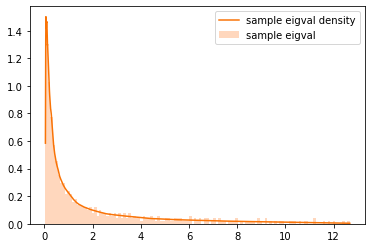

In [53]:
sample_1.hist(
    show_lambdas=True,
    show_lambdas_density=True,
)

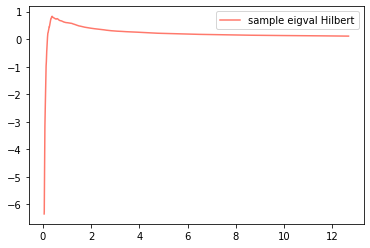

In [54]:
sample_1.hist(
    show_lambdas_Hilbert=True,
)

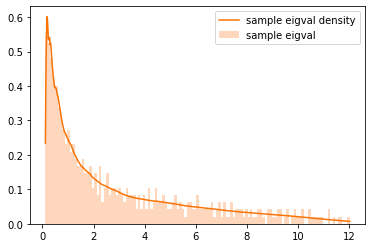

In [55]:
sample_2.hist(
    show_lambdas=True,
    show_lambdas_density=True,
)

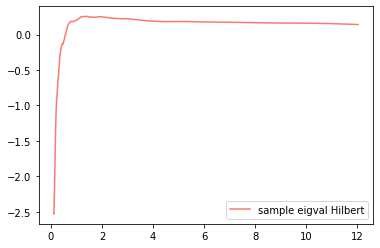

In [56]:
sample_2.hist(
    show_lambdas_Hilbert=True,
)

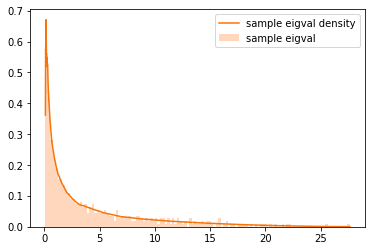

In [57]:
sample_3.hist(
    show_lambdas=True,
    show_lambdas_density=True,
)

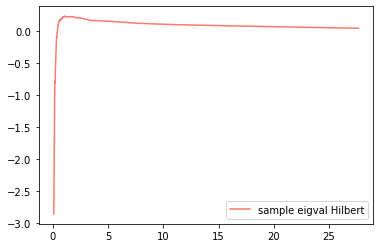

In [58]:
sample_3.hist(
    show_lambdas_Hilbert=True,
)

## 2.2. Rotationally invariant estimators (RIEs) of correlations - shrinkage

### 2.2.1. Introduction

In large-dimensional statistics (recall, both the number of entities $N$ and the number of samples $T$ large and of comparable size, i.e., $q = N/T \sim 1$), the sample estimator $\mathbf{E}$ of correlations is not optimal; its mean squared error (MSE; here known as the _Frobenius norm_) as compared to the "true" (population) correlation matrix $\mathbf{C}$, i.e., $\textrm{Tr} \, (\mathbf{E} - \mathbf{C})^{2}$, does _not_ tend to zero with an increasing number of samples $T$, as it is in standard multivariate statistics ($N$ small compared to $T$). Another way of looking at the problem is to notice that usual statistical estimators have _high variance_ in the large-dimensional limit; the "truth" about the underlying correlations is hidden behind a lot of "noise".

Since estimating correlations is a very common task in diverse areas of science, and often happens in the "big data regime" discussed here (with examples from physics, finance, genomics and bioinformatics, acoustics and signal processing, image processing, cancer research, neuroscience, and others), one is faced with a challenge of constructing _optimal estimators_ $\mathbf{\Xi}$ of correlations, that is, with a lower MSE than the standard sample estimator $\mathbf{E}$. These estimators will have a higher bias than $\mathbf{E}$, but much lower variance, having effectively a lower MSE ([recall](https://en.wikipedia.org/wiki/Bias_of_an_estimator) that MSE = bias$^{2}$ + variance). This is reminiscent of the [James-Stein estimator](https://en.wikipedia.org/wiki/James%E2%80%93Stein_estimator) of multidimensional ($N \geq 3$) mean, which is biased, but has a lower MSE than the standard sample estimator.

One recent approach to the problem is the following: Suppose we do not have any prior information on the eigenvectors of $\mathbf{\Xi}$, no bias in any particular direction in their $N$-dimensional space; then, the only available basis is that of the observed sample estimator $\mathbf{E}$. Let's thus try to construct a MSE-optimal estimator with the same eigenbasis as $\mathbf{E}$, i.e. $\mathbf{u}_{i}$, but with some different eigenvalues $\xi_{i}$:
$$
\mathbf{\Xi} = \sum_{i = 1}^{N} \xi_{i} | \mathbf{u}_{i} \rangle \langle \mathbf{u}_{i} |
$$
In other words, we are "cleaning" the "noise" in the sample eigenvalues $\lambda_{i}$: replacing them by different $\xi_{i}$ so that the MSE of the resulting estimator $\mathbf{\Xi}$ is lower than that of $\mathbf{E}$. This form is called _rotationally invariant estimators_ (RIEs). (The intuition behind this name is that, as mentioned, there is no bias in any particular direction. Furthermore, this Ansatz may be understood in Bayesian language as originating from a prior distribution on $\mathbf{C}$ which is invariant under orthogonal similarity transformations.)

Every such prescription for constructing an estimator with a better MSE is called _shrinkage_; we will observe this visually later on when plotting histograms of both the "noisy" $\lambda_{i}$'s and the "cleaned" $\xi_{i}$'s - the latter will be narrower ("shrunk") as compared to the former, sculpted more tightly around the true underlying eigenvalues of $\mathbf{C}$. We will thus refer to $\xi_{i}$ as _shrunk eigenvalues_.

### 2.2.2. RIEs with given eigenvalues

Since the `SampleEigenvalues` class knows about the sample eigenvectors (the `E_eigvec` attribute), it also provides a simple method to calculate a RIE $\mathbf{\Xi} = \sum_{i = 1}^{N} \xi_{i} | \mathbf{u}_{i} \rangle \langle \mathbf{u}_{i} | = \mathbf{U} \, \textrm{diag}(\mathbf{\xi}) \, \mathbf{U}^{\top}$ when given some eigenvalues $\xi_{i}$.

For instance:

In [59]:
sample_1.rie(x=sample_1.E_eigval).shape

(500, 500)

### 2.2.3. Frobenius ratio

In the case when we have simulated our dataset, like we just did, and we know the "true" correlation matrix $\mathbf{C}$, we have access to the method `frobenius_ratio`, with parameters `x` and `C`. It calculates the Frobenius norm (the Frobenius norm squared of a matrix $\mathbf{W}$ is defined as $\textrm{Tr} \, \mathbf{W} \mathbf{W}^{\top}$) of the difference $(\mathbf{\Xi}(\mathbf{x}) - \mathbf{C})$, for a RIE with eigenvalues $\mathbf{x}$, and then the Frobenius norm of the difference $(\mathbf{E} - \mathbf{C})$; it returns their ratio. This ratio is a measure of how much better the RIE with eigenvalues `x` estimates the true correlation matrix as compared to the sample estimator.

For instance:

In [60]:
sample_1.frobenius_ratio(
    x=sample_1.E_eigval,
    C=sim_1.population_covariance.C
)

1.0000000000000002

## 2.3. The oracle estimator - the moving-window K-fold cross-validation estimation procedure

### 2.3.1. Introduction

Recall the philosophy of RIEs we have outlined above: Our goal is to minimize an error (here: MSE, or "Frobenius norm", as it is called in the context of matrices) between the true correlation matrix $\mathbf{C}$, which is unknown, and its estimator $\mathbf{\Xi}$. We choose a particular Ansatz, $\mathbf{\Xi} = \sum_{i = 1}^{N} \xi_{i} | \mathbf{u}_{i} \rangle \langle \mathbf{u}_{i} |$, termed a "rotationally invariant estimator" (RIE), which means that it has the same eigenvectors $\mathbf{u}_{i}$ as the sample estimator $\mathbf{E}$, but some new eigenvalues, $\xi_{i}$, to be determined via said minimization process. Indeed, these "shrunk eigenvalues" can be found in a straightforward way, as the problem is quadratic, $\xi^{ \textrm{oracle} }_{i} = \langle \mathbf{u}_{i} | \mathbf{C} | \mathbf{u}_{i} \rangle$. In this form, they are referred to as "oracle eigenvalues", since they require oracular insight into the underlying $\mathbf{C}$. Miraculously, however, in the large-dimensional limit ($N, T \to \infty$, with $q = N/T$ fixed), it is shown that this formula can be entirely expressed through observable quantities, that is, dependent on the observed sample eigenvalues $\lambda_{i}$. This is the broad topic of "shrinkage", and we have discussed several forms of it.

On another note, the oracle eigenvalues can be estimated with an altogether different procedure, cf. section 8.2 of a paper by Joël Bun, Jean-Philippe Bouchaud, Marc Potters ([Cleaning large correlation matrices: tools from random matrix theory](https://arxiv.org/abs/1610.08104), 2016), which we briefly describe.

We take the total number of samples we have, $T_{\textrm{total}}$, and consider a series of $K$ pairs of moving windows. Each such pair consists of a "training" ("in-sample") window of length $T$, and a "testing" ("out-of-sample") window of length $T_{\textrm{out}}$. Notice that everywhere so far we have only used the final $T$ samples out of $T_{\textrm{total}}$; this here is the very place where we need the entire dataset. This pair of windows of length $(T + T_{\textrm{out}})$ we keep shifting $K$ times through the whole dataset; this in particular implies, $K = \lfloor (T_{\textrm{total}} - T) / T_{\textrm{out}} \rfloor$. For the $\mu$-th fold ($\mu = 0, \ldots, K - 1$) denote $t_{\mu} = T + \mu T_{\textrm{out}} + 1$; following the convention used in the paper and in this notebook that the temporal index starts from $1$, we see that the $\mu$-th test fold has indices from $t_{\mu}$ up to $t_{\mu} + T_{\textrm{out}} - 1$ (both inclusive), while the $\mu$-th train fold stretches between $t_{\mu} - T$ and $t_{\mu} - 1$. (In the zero-indexed Python code we thus have `t_mu = T + mu * T_out`.)

For each fold $\mu$, we denote by $\mathbf{E}^{\textrm{train}, \mu}$ the sample estimator calculated on the current train fold, and in particular $| \mathbf{u}^{\textrm{train}, \mu}_{i} \rangle$ its eigenvectors, and by $\mathbf{E}^{\textrm{test}, \mu}$ the one calculated on the current test fold. Then the claim is that the oracle eigenvalues can be estimated by the mean over all the folds of the average test sample estimator in the state given by any train sample eigenvector,
$$
\xi^{\textrm{mwcv}}_{i} = \frac{1}{K} \sum_{\mu = 0}^{K - 1} \langle \mathbf{u}^{\textrm{train}, \mu}_{i} | \mathbf{E}^{\textrm{test}, \mu} | \mathbf{u}^{\textrm{train}, \mu}_{i} \rangle
$$

An intuition behind this formula is that the unknown $\mathbf{C}$ in the oracle formula, $\xi^{\textrm{oracle}}_{i} = \langle \mathbf{u}_{i} | \mathbf{C} | \mathbf{u}_{i} \rangle$ can be approximated by the out-of-sample, i.e., unknown from the point of view of an in-sample observer, estimator.

From the point of view of program design, this out-of-sample procedure is a part of the `SampleEigenvalues` class, the `calculate_oracle_mwcv` method. This method is automatically called when the class is instantiated with a parameter `T_out`. The resulting number of folds then resides in the attribute `K`. The out-of-sample estimate of the oracle eigenvalues becomes available in the attribute `xi_oracle_mwcv`, their standard deviations (over all the folds) in `xi_oracle_mwcv_std`, while all the actual values per fold are in the $K \times N$ array `xi_oracle_mwcv_all`.

Furthermore, we fit isotonic regression to these oracle eigenvalues; the transformed eigenvalues reside in `xi_oracle_mwcv_iso`.

### 2.3.2. Example 1

First, check that all the relevant attributes have been computed:

In [61]:
sample_1.K

10

In [62]:
sample_1.xi_oracle_mwcv_all.shape

(10, 500)

In [63]:
sample_1.xi_oracle_mwcv.shape

(500,)

In [64]:
sample_1.xi_oracle_mwcv_std.shape

(500,)

In [65]:
sample_1.xi_oracle_mwcv_iso.shape

(500,)

The `hist` method can be made to show the estimated oracle eigenvalues, as well as the isotonic regression fit, plus their Epanechnikov-kernel estimated densities and/or Hilbert transforms.

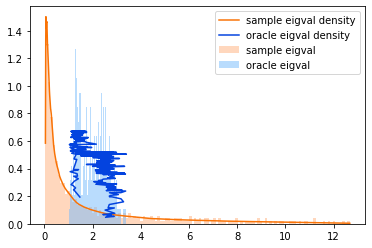

In [66]:
sample_1.hist(
    show_lambdas=True,
    show_lambdas_density=True,
    show_oracle_mwcv=True,
    show_oracle_mwcv_density=True,
)

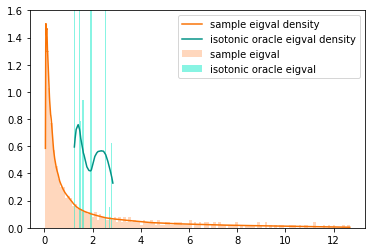

In [67]:
sample_1.hist(
    show_lambdas=True,
    show_lambdas_density=True,
    show_oracle_mwcv_iso=True,
    show_oracle_mwcv_iso_density=True,
    ylim=(0, 1.6)
)

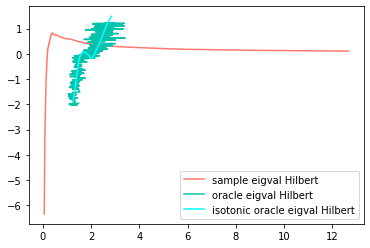

In [68]:
sample_1.hist(
    show_lambdas_Hilbert=True,
    show_oracle_mwcv_Hilbert=True,
    show_oracle_mwcv_iso_Hilbert=True,
)

We also have the `plot` method that by default shows a scatter plot of the estimated oracle eigenvalues versus the sample eigenvalues; it may be made to show the error bars of the former (possible thanks to the fact that each oracle eigenvalue is estimated $K$ times), as well as a line plot of the isotonic regression fit.

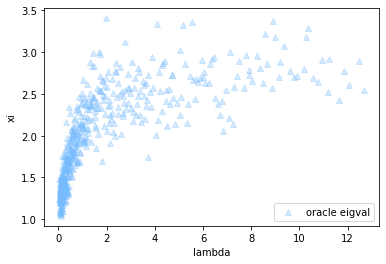

In [69]:
sample_1.plot(
    show_oracle_mwcv=True,
)

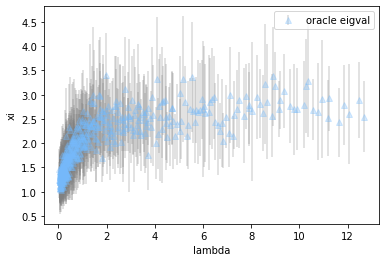

In [70]:
sample_1.plot(
    show_oracle_mwcv=True,
    show_oracle_mwcv_errors=True
)
plt.show()

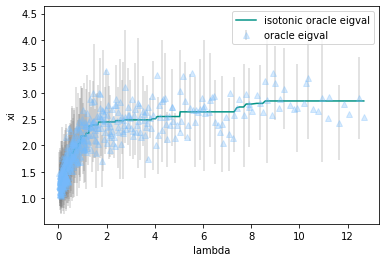

In [71]:
sample_1.plot(
    show_oracle_mwcv=True,
    show_oracle_mwcv_errors=True,
    show_oracle_mwcv_errors_every=3,
    show_oracle_mwcv_iso=True
)

The Frobenius ratios for the estimated oracle eigenvalues, as well as their isotonic regression fit:

In [72]:
sample_1.frobenius_ratio(
    x=sample_1.xi_oracle_mwcv,
    C=sim_1.population_covariance.C
)

0.1331668589909761

In [73]:
sample_1.frobenius_ratio(
    x=sample_1.xi_oracle_mwcv_iso,
    C=sim_1.population_covariance.C
)

0.12470970578374843

### 2.3.3. Example 2

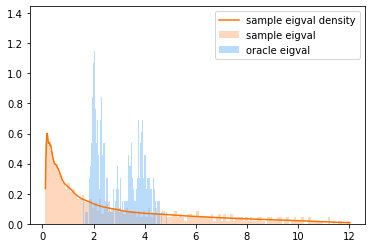

In [74]:
sample_2.hist(
    show_lambdas=True,
    show_lambdas_density=True,
    show_oracle_mwcv=True
)

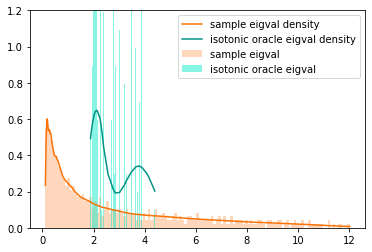

In [75]:
sample_2.hist(
    show_lambdas=True,
    show_lambdas_density=True,
    show_oracle_mwcv_iso=True,
    show_oracle_mwcv_iso_density=True,
    ylim=(0, 1.2)
)

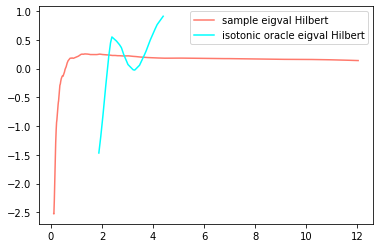

In [76]:
sample_2.hist(
    show_lambdas_Hilbert=True,
    show_oracle_mwcv_iso_Hilbert=True,
)

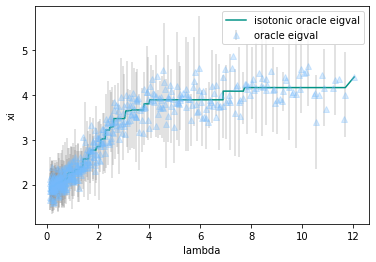

In [77]:
sample_2.plot(
    show_oracle_mwcv=True,
    show_oracle_mwcv_errors=True,
    show_oracle_mwcv_errors_every=3,
    show_oracle_mwcv_iso=True
)

The Frobenius ratios for the estimated oracle eigenvalues, as well as their isotonic regression fit:

In [78]:
sample_2.frobenius_ratio(
    x=sample_2.xi_oracle_mwcv,
    C=sim_2.population_covariance.C
)

0.23051436181224697

In [79]:
sample_2.frobenius_ratio(
    x=sample_2.xi_oracle_mwcv_iso,
    C=sim_2.population_covariance.C
)

0.2241363402944205

### 2.3.4. Example 3

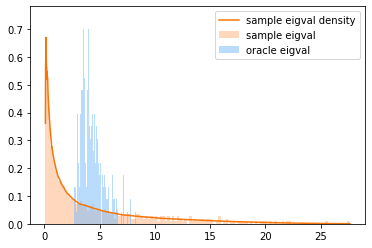

In [80]:
sample_3.hist(
    show_lambdas=True,
    show_lambdas_density=True,
    show_oracle_mwcv=True
)

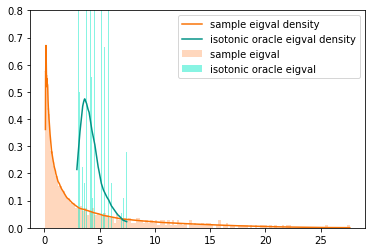

In [81]:
sample_3.hist(
    show_lambdas=True,
    show_lambdas_density=True,
    show_oracle_mwcv_iso=True,
    show_oracle_mwcv_iso_density=True,
    ylim=(0, 0.8)
)

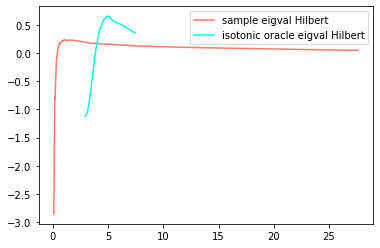

In [82]:
sample_3.hist(
    show_lambdas_Hilbert=True,
    show_oracle_mwcv_iso_Hilbert=True,
)

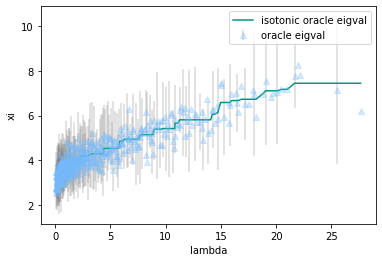

In [83]:
sample_3.plot(
    show_oracle_mwcv=True,
    show_oracle_mwcv_errors=True,
    show_oracle_mwcv_errors_every=3,
    show_oracle_mwcv_iso=True
)

The Frobenius ratios for the estimated oracle eigenvalues, as well as their isotonic regression fit:

In [84]:
sample_3.frobenius_ratio(
    x=sample_3.xi_oracle_mwcv,
    C=sim_3.population_covariance.C
)

0.3446002653375403

In [85]:
sample_3.frobenius_ratio(
    x=sample_3.xi_oracle_mwcv_iso,
    C=sim_3.population_covariance.C
)

0.3404635846119887

# 3. Shrinkage cleaning of sample eigenvalues: Ledoit-Péché shrinkage (`LedoitPecheShrinkage` class)

In this section, we will discuss another module of the library, `shrinkage.rie_lp`, containing the `LedoitPecheShrinkage` class that allow us to perform one variation of _nonlinear shrinkage_, i.e. nonlinear cleaning of the noise present in the sample estimator $\mathbf{E}$ of correlations in the large-dimensional limit.

In [5]:
from shrinkage.rie_lp import LedoitPecheShrinkage

## 3.1. Ledoit-Péché shrinkage and random matrix theory

An optimal set of "cleaned" eigenvalues $\xi_{i}$ is found by minimizing the MSE (Frobenius norm) between $\mathbf{\Xi}$ and $\mathbf{C}$. One does this under an assumption of a certain model for the noise, and then hope that in the large-dimensional limit the result extends to other probability distributions not too dissimilar to the assumed model; similarly like the central limit theorem is derived for Gaussian variables, but then holds for a whole class of distributions, in the limit of a large number of variables. The simplest model of the noise is Gaussian, and in fact, the "sandwich" model discussed above, $\mathbf{Y} = \sqrt{\mathbf{C}} \mathbf{X} \sqrt{\mathbf{A}}$, with $\mathbf{X}$ IID standard normal. In this case, the problem of minimizing the MSE can be solved exactly.

There is however an important observation: the resulting optimal $\xi_{i}$'s depend on the true correlation matrix $\mathbf{C}$; indeed, it is easy to minimize the MSE with a RIE Ansatz:
$$
\xi^{ \textrm{oracle} }_{i} = \langle \mathbf{u}_{i} | \mathbf{C} | \mathbf{u}_{i} \rangle
$$
This is not surprising: we are, after all, considering an error as compared to $\mathbf{C}$, so the solution naturally depends on it. But for this reason, it is hardly useful: $\mathbf{C}$ is unknown in a real-world scenario (and we are doing our best in this library to estimate it!). Since the solution depends on an unknown quantity, it is termed an _oracle estimator_. We will come back later to this topic.

However, it is a known phenomenon that a MSE-optimal estimator may in fact be independent of the parameters being estimated; indeed, miraculously, it can be proven here that in the large-dimensional limit ($N, T \to \infty$ with $q = N/T$ fixed) the dependence on $\mathbf{C}$ disappears, and the "cleaned" eigenvalues $\xi_{i}$ can be expressed solely in terms of observable quantities, namely the sample eigenvalues $\lambda_{i}$, readily estimated from the observed data $\mathbf{Y}$ (this, recall, is performed by the class `SampleEigenvalues`).

This miracle is demonstrated by employing methods of [random matrix theory](https://en.wikipedia.org/wiki/Random_matrix) (RMT). We will not present the derivation, but we do need some definitions. For a random matrix $\mathbf{E}$, say our sample estimator:

- The basic object is the _resolvent_: a matrix function of a complex argument $z$,
  $$
  \mathbf{G}_{ \mathbf{E} } (z) \equiv (z \mathbf{1} - \mathbf{E})^{-1}
  $$
  This looks like a random function, due to the randomness of $\mathbf{E}$, but in the large-$N$ limit, it is self-averaging, i.e. independent of any realization of $\mathbf{E}$, but converging to a deterministic matrix, $\mathbf{G}_{ \mathbf{E} } (z) = \langle \mathbf{G}_{ \mathbf{E} } (z) \rangle$.

- Its normalized trace:
  $$
  G_{ \mathbf{E} } (z) \equiv \frac{1}{N} \textrm{Tr} \, \mathbf{G}_{ \mathbf{E} } (z) = \int \textrm{d} \lambda \rho_{ \mathbf{E} } (\lambda) \frac{1}{z - \lambda}
  $$
  is called the _Stieltjes transform_, and encodes information about the spectrum of $\mathbf{E}$.

- Indeed, a basic characteristic of the spectrum is the _eigenvalue density_, $\rho_{ \mathbf{E} } (\lambda)$. Another characteristic is so-called [_Hilbert transform_](https://en.wikipedia.org/wiki/Hilbert_transform) of the eigenvalues:
  $$
  h_{ \mathbf{E} } (\lambda) \equiv \textrm{pv} \int \textrm{d} \lambda' \rho_{ \mathbf{E} } (\lambda') \frac{1}{\lambda - \lambda'}
  $$
  ("pv" stands for ["principal value"](https://en.wikipedia.org/wiki/Principal_value) of the integral). Now, it turns out that both these quantities are encoded in the Stieltjes transform; indeed, evaluating it close to the real axis produces the Hilbert transform as the real part of the result, and the eigenvalue density as the imaginary part:
  $$
  G_{ \mathbf{E} } (\lambda - \textrm{i} \epsilon) = h_{ \mathbf{E} } (\lambda) + \textrm{i} \pi \rho_{ \mathbf{E} } (\lambda)
  $$
  (where implicitly, $\epsilon \to 0^{+}$).

- A small modification of the resolvent (and Stieltjes transform) is the so-called _M-transform_ (or _moment generating function_), in a matrix form:
  $$
  \mathbf{M}_{ \mathbf{E} } (z) \equiv z \mathbf{G}_{ \mathbf{E} } (z) - 1
  $$
  and, after taking the normalized trace of both sides, a scalar form:
  $$
  M_{ \mathbf{E} } (z) \equiv z G_{ \mathbf{E} } (z) - 1
  $$
  (Its expansion in $1/z$ is comprised of the probabilistic moments of $\mathbf{E}$, hence the name.) We will mainly use the M-transform, rather than the resolvent/Stieltjes transform.

- Now carry out the following procedure: Take the scalar M-transform, $M_{ \mathbf{E} } (z)$, and invert it functionally - this yields the so-called _N-transform_:
  $$
  M_{ \mathbf{E} } ( N_{ \mathbf{E} } (z) ) = N_{ \mathbf{E} } ( M_{ \mathbf{E} } (z) ) = z
  $$
  Further, a numerical inverse of the N-transform is called the $\chi$-_transform_:
  $$
  \chi_{ \mathbf{E} } (z) \equiv \frac{ 1 }{ N_{ \mathbf{E} } (z) }
  $$

Having presented all these definitions, we return to the problem of optimal shrinkage in the case of the "sandwich" model. Let's simplify the model even more by assuming for now $\mathbf{A} = \mathbf{1}$, i.e. no auto-correlations; the model is thus $\mathbf{Y} = \sqrt{\mathbf{C}} \mathbf{X}$, with $\mathbf{X}$ IID standard normal. The MSE-optimal shrunk eigenvalues in this case has been derived - with techniques of random matrix theory - by Olivier Ledoit and Sandrine Péché ([_Eigenvectors of some large sample covariance matrix ensembles_](https://arxiv.org/abs/0911.3010), 2009). As mentioned, a "miracle" happens in that the resulting expression is independent of $\mathbf{C}$, i.e. the parameters being estimated, but fully described by observable quantities; these observables are related to the spectrum of the sample estimator $\mathbf{E}$, and in fact are the eigenvalue density $\rho_{ \mathbf{E} } (\lambda)$ and Hilbert transform $h_{ \mathbf{E} } (\lambda)$, introduced above. For each sample ("noisy") eigenvalue $\lambda_{i}$, denote intermediate variables:
$$
\alpha_{i} \equiv q \left( \lambda_{i} h_{ \mathbf{E} } (\lambda_{i}) - 1 \right) , \qquad \beta_{i} \equiv \pi q \lambda_{i} \rho_{ \mathbf{E} } (\lambda_{i})
$$
(recall, $q = N/T$). The _Ledoit-Péché shrinkage formula_ is then:
$$
\frac{ \xi^{ \textrm{LP} }_{i} }{ \lambda_{i} } = \frac{ 1 }{ (\alpha_{i} + 1)^{2} + \beta_{i}^{2} }
$$
It is implemented in the `LedoitPecheShrinkage` class, outlined below.

## 3.2. Ledoit-Péché shrinkage

### 3.2.1. Introduction

The Ledoit-Péché formula (which, recall, holds for the "sandwich" model with no auto-correlations) is implemented in the `LedoitPecheShrinkage` class in the `shrinkage.rie_lp` module. This is a child class of `SampleEigenvalues`, so have access to the sample estimator, its eigensystem, as well as the cross-validation-estimated oracle eigenvalues, and their isotonic regression fit.

Note: `LedoitPecheShrinkage` will in turn be a parent class of various other nonlinear shrinkage methods, valid for particular models of $\mathbf{A}$; for instance, the `VarmaShrinkage` class, which implements formulas for VARMA auto-correlations.

We instantiate the class with the same parameters as `SampleEigenvalues`. It will perform:

- calculation of the Ledoit-Péché intermediate variables $\alpha_{i}$, $\beta_{i}$, and $u_{i}$, as well as the actual shrunk eigenvalues, $\xi^{ \textrm{LP} }_{i}$; they reside in the attributes `alpha`, `beta`, `u_range`, `xi_LP`;

- Epanechnikov kernel estimation of their density $\rho_{ \mathbf{\Xi} } (\xi)$ and Hilbert transform $h_{ \mathbf{\Xi} } (\xi)$; attributes `xi_LP_kernel_density` and `xi_LP_kernel_Hilbert`.

Additionally and optionally we may provide a `tau_list_eff` to the constructor. It will iterate over its members, $\tau_{\textrm{eff}}$, for each computing a certain modified, _effective_ $T_{\textrm{eff}} = T (1 - \textrm{e}^{- 1 / \tau_{\textrm{eff}}}) \sim T / \tau_{\textrm{eff}}$. For the corresponding effective $q_{\textrm{eff}} = N / T_{\textrm{eff}}$, we find the Ledoit-Péché shrunk eigenvalues. We now find $\tau_{\textrm{eff}}$ such that it minimizes the MSE between such effective LP shrunk eigenvalues and the cross-validation-estimated oracle eigenvalues.

In [87]:
tau_eff_list = np.arange(0.1, 5.1, 0.1)

### 3.2.2. Example 1

In [88]:
lp_1 = LedoitPecheShrinkage(
    Y=sim_1.Y,
    T=T,
    T_out=T_out,
    tau_eff_list=tau_eff_list
)

The Ledoit-Péché intermediate variables and the final result:

In [89]:
lp_1.alpha.shape

(500,)

In [90]:
lp_1.beta.shape

(500,)

In [91]:
lp_1.u_range.shape

(500,)

In [92]:
lp_1.xi_LP.shape

(500,)

Kernel estimates for $\mathbf{\Xi}$:

In [93]:
lp_1.xi_LP_kernel_density.shape

(500,)

In [94]:
lp_1.xi_LP_kernel_Hilbert.shape

(500,)

The same for the best effective $T_{\textrm{eff}}$:

In [95]:
lp_1.xi_LP_eff_best_oracle_mwcv.shape

(500,)

In [96]:
lp_1.xi_LP_eff_best_oracle_mwcv_kernel_density.shape

(500,)

In [97]:
lp_1.xi_LP_eff_best_oracle_mwcv_kernel_Hilbert.shape

(500,)

... while the optimal values of the fitted $\tau$ and the corresponding $T_{\textrm{eff}}$:

In [98]:
lp_1.tau_eff_best_oracle_mwcv

1.8000000000000003

In [99]:
lp_1.T_eff_best_oracle_mwcv

426.24657926256714

The `hist` method is extended appropriately; for instance:

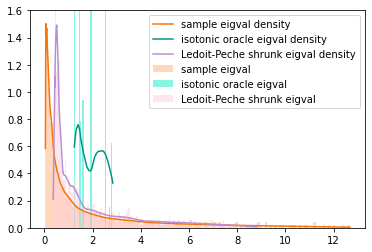

In [100]:
lp_1.hist(
    show_lambdas=True,
    show_lambdas_density=True,
    show_oracle_mwcv_iso=True,
    show_oracle_mwcv_iso_density=True,
    show_xi_LP=True,
    show_xi_LP_density=True,
    ylim=(0, 1.6),
)

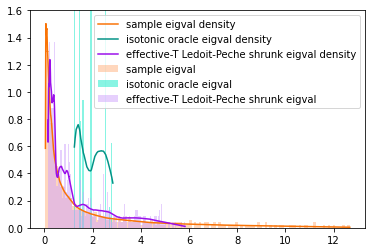

In [101]:
lp_1.hist(
    show_lambdas=True,
    show_lambdas_density=True,
    show_oracle_mwcv_iso=True,
    show_oracle_mwcv_iso_density=True,
    show_xi_LP_eff_best_oracle_mwcv=True,
    show_xi_LP_eff_best_oracle_mwcv_density=True,
    ylim=(0, 1.6)
)

The `plot` method is similarly extended:

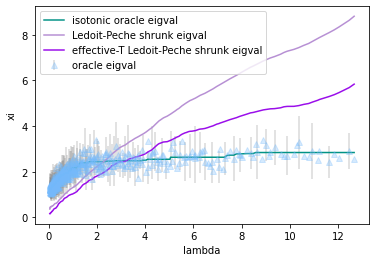

In [102]:
lp_1.plot(
    show_oracle_mwcv=True,
    show_oracle_mwcv_errors=True,
    show_oracle_mwcv_errors_every=3,
    show_oracle_mwcv_iso=True,
    show_xi_LP=True,
    show_xi_LP_eff_best_oracle_mwcv=True,
)

The relevant Frobenius ratios:

In [103]:
lp_1.frobenius_ratio(
    x=lp_1.xi_LP,
    C=sim_1.population_covariance.C
)

0.5269046129516535

In [104]:
lp_1.frobenius_ratio(
    x=lp_1.xi_LP_eff_best_oracle_mwcv,
    C=sim_1.population_covariance.C
)

0.3276028432526788

### 3.2.3. Example 2

In [105]:
lp_2 = LedoitPecheShrinkage(
    Y=sim_2.Y,
    T=T,
    T_out=T_out,
    tau_eff_list=tau_eff_list
)

In [106]:
lp_2.tau_eff_best_oracle_mwcv

0.6

In [107]:
lp_2.T_eff_best_oracle_mwcv

811.1243971624382

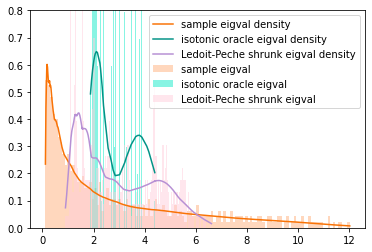

In [108]:
lp_2.hist(
    show_lambdas=True,
    show_lambdas_density=True,
    show_oracle_mwcv_iso=True,
    show_oracle_mwcv_iso_density=True,
    show_xi_LP=True,
    show_xi_LP_density=True,
    ylim=(0, 0.8)
)

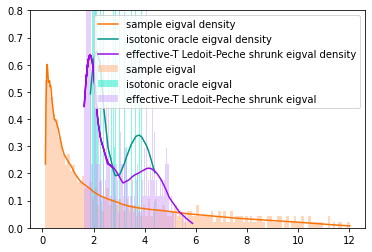

In [109]:
lp_2.hist(
    show_lambdas=True,
    show_lambdas_density=True,
    show_oracle_mwcv_iso=True,
    show_oracle_mwcv_iso_density=True,
    show_xi_LP_eff_best_oracle_mwcv=True,
    show_xi_LP_eff_best_oracle_mwcv_density=True,
    ylim=(0, 0.8)
)

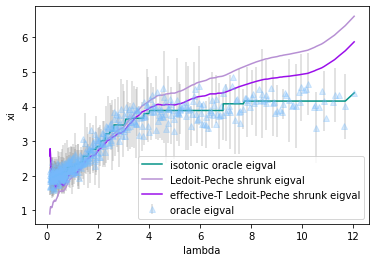

In [110]:
lp_2.plot(
    show_oracle_mwcv=True,
    show_oracle_mwcv_errors=True,
    show_oracle_mwcv_errors_every=3,
    show_oracle_mwcv_iso=True,
    show_xi_LP=True,
    show_xi_LP_eff_best_oracle_mwcv=True,
)

In [111]:
lp_2.frobenius_ratio(
    x=lp_2.xi_LP,
    C=sim_2.population_covariance.C
)

0.3324138222409932

In [112]:
lp_2.frobenius_ratio(
    x=lp_2.xi_LP_eff_best_oracle_mwcv,
    C=sim_2.population_covariance.C
)

0.2629995851226816

### 3.2.4. Example 3

In [113]:
lp_3 = LedoitPecheShrinkage(
    Y=sim_3.Y,
    T=T,
    T_out=T_out,
    tau_eff_list=tau_eff_list
)

In [114]:
lp_3.tau_eff_best_oracle_mwcv

1.2000000000000002

In [115]:
lp_3.T_eff_best_oracle_mwcv

565.4017914929217

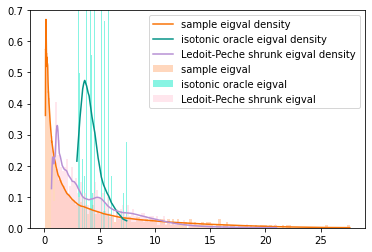

In [116]:
lp_3.hist(
    show_lambdas=True,
    show_lambdas_density=True,
    show_oracle_mwcv_iso=True,
    show_oracle_mwcv_iso_density=True,
    show_xi_LP=True,
    show_xi_LP_density=True,
    ylim=(0, 0.7)
)

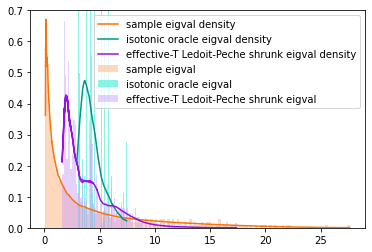

In [117]:
lp_3.hist(
    show_lambdas=True,
    show_lambdas_density=True,
    show_oracle_mwcv_iso=True,
    show_oracle_mwcv_iso_density=True,
    show_xi_LP_eff_best_oracle_mwcv=True,
    show_xi_LP_eff_best_oracle_mwcv_density=True,
    ylim=(0, 0.7)
)

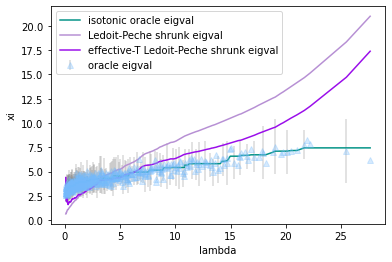

In [118]:
lp_3.plot(
    show_oracle_mwcv=True,
    show_oracle_mwcv_errors=True,
    show_oracle_mwcv_errors_every=3,
    show_oracle_mwcv_iso=True,
    show_xi_LP=True,
    show_xi_LP_eff_best_oracle_mwcv=True,
)

In [119]:
lp_3.frobenius_ratio(
    x=lp_3.xi_LP,
    C=sim_3.population_covariance.C
)

0.5953772895150997

In [120]:
lp_3.frobenius_ratio(
    x=lp_3.xi_LP_eff_best_oracle_mwcv,
    C=sim_3.population_covariance.C
)

0.3706319540288023

# 4. VARMA shrinkage (`VarmaShrinkage` class)

In [6]:
from shrinkage.rie_varma import VarmaShrinkage

## 4.1. Shrinkage with auto-correlations

The Ledoit-Péché solution holds, as mentioned, for the "sandwich" model with $\mathbf{A} = \mathbf{1}$, i.e. no auto-correlations. For the full model, $\mathbf{Y} = \sqrt{\mathbf{C}} \mathbf{X} \sqrt{\mathbf{A}}$, a random matrix theory calculation may be carried out, too, and the resulting expression for the MSE-optimal shrunk eigenvalues now involves the $\chi$-transform of the auto-correlation matrix $\mathbf{A}$, as well as the intermediate variables present in the Ledoit-Péché formula, all defined above:
$$
\frac{ \xi_{i} }{ \lambda_{i} } = \frac{ \textrm{Im} \, \chi_{ \mathbf{A} } (u_{i}) }{ \textrm{Im} \, u_{i} } , \qquad u_{i} \equiv \alpha_{i} + \textrm{i} \beta_{i}
$$
The logic here is the following: We need to assume some model of auto-correlations, some matrix $\mathbf{A}$; for this model, we should be able to calculate the $\chi$-transform, $\chi_{ \mathbf{A} } (z)$; once this function is available, we compute the shrunk eigenvalues from the Ledoit-Péché variables $\alpha_{i}$ and $\beta_{i}$.

One might protest that $\mathbf{A}$ should in principle be estimated from the data itself. However, this here approach again demonstrates the power of an "effective" description: we choose some tractable model of auto-correlations, with some parameters that we eventually _fit_ to data; what matters is that the final estimator even better reflects the truth of the underlying $\mathbf{C}$.

A broad family of models for $\mathbf{A}$, which are both tractable and inclusive of a wide range behaviors, is the [VARMA](https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model) class, see above. We have calculated the $\chi$-transform of $\mathbf{A}$ for several sub-models here, namely VMA(1), VAR(1), VARMA(1, 1), VMA(2), and VAR(2); see below.

## 4.2. Fixed VARMA parameters

In order to perform shrinkage with the VARMA formula, instead of the Ledoit-Péché one, we instantiate the relevant class. Now, we may proceed in two ways. One is to suppose we know what values the VARMA parameters should take. In a real-world situation, we wouldn't know the data-generating process, and so this would need to be some educated guess. Below, we shall demonstrate an alternative way of _estimating_ those VARMA parameters. But for now, set them to some given fixed values, via the `set_params` method, taking:

- either an `a_list`, containing $(r_{2} + 1)$ "MA" parameters, $a_{0}, a_{1}, \ldots, a_{ r_{2} }$, and a `b_list`, containing $r_{1}$ "AR" parameters, $b_{1}, \ldots, b_{ r_{1} }$;

- or $\tau$, which means we want a particular VAR(1) model, with $a_{0}$, $b_{1}$ related to $\tau$ by a formula above; this is a model with simple exponentially-decaying auto-correlations.

Note: We emphasize that these parameters should in principle be thought of as "trainable", found by some fitting procedure based on the observed sample eigenvalues; in this section, however, we provide these trainable weights by hand. In effect, we're now learning only how to make _predictions_ for fixed parameters, not yet any _fitting_.

### 4.2.1. Example 1

#### 4.2.1.1. Setting VARMA parameters

In [122]:
varma_1 = VarmaShrinkage(
    Y=sim_1.Y,
    T=T,
    T_out=T_out,
    tau_eff_list=tau_eff_list
)

varma_1.set_params(
    tau=sim_1.auto_covariance.tau
)

varma_1.name

'VAR(1)'

#### 4.2.1.2. Getting VARMA parameters

At any moment we may retrieve the paramaters of a given VARMA shrinkage model via the `get_params` method:

In [123]:
varma_1.get_params()

{'a_list': array([0.69755493]), 'b_list': array([0.71653131])}

Note that we have an `a_list` and `b_list` here; indeed, the exp-decay model is a particular case of VAR(1).

#### 4.2.1.3. Getting the auto-correlation matrix

Having now instantiated a particular VARMA shrinkage, here VAR(1) shrinkage, we get access to:

- the auto-correlation matrix $\mathbf{A}$, via the attribute `A`,

- its scalar M-transform, $M_{ \mathbf{A} } (z)$, via the method `calculate_M_transform_A`, called with a real and imaginary parts of $z$.

Technical note: The class `VarmaShrinkage` is a child not only of `LedoitPecheShrinkage`, but also of `Varma` (from `shrinkage.varma`), and the latter provides these functionalities.

In [124]:
varma_1.A.shape

(1000, 1000)

In [125]:
varma_1.calculate_M_transform_A(z_re=0.2, z_im=0.3)

(-0.485246395434082-0.5740889688734291j)

#### 4.2.1.4. Calculating the VARMA-shrunk eigenvalues

Now, a fundamental method of this shrinkage class is `calculate_xi`, which performs the "cleaning" - the move from the "noisy" $\lambda_{i}$ to the "clean"/"shrunk" $\xi_{i}$.

In [126]:
varma_1.calculate_xi(
    calculate_epanechnikov_estimates_xi=True
)

The shrunk eigenvalues then reside in the `xi` attribute.

In [127]:
varma_1.xi.shape

(500,)

The flag `calculate_epanechnikov_estimates_xi=True` is needed to calculate the Epanechnikov-kernel estimates of the density and Hilbert transform of the shrunk eigenvalues.

In [128]:
varma_1.xi_kernel_density.shape

(500,)

In [129]:
varma_1.xi_kernel_Hilbert.shape

(500,)

Prediction in the VARMA case amounts to two operations:

- First, solving an equation $M_{\mathbf{A}}(1 / \chi) = u$ in variable $\chi$, for given complex $u$, where recall $M_{\mathbf{A}}(\cdot)$ is the M-transform of the auto-correlation matrix $\mathbf{A}$; in other words, $\chi = \chi_{\mathbf{A}}(u) = 1 / N_{\mathbf{A}}(u)$, making use of the $\chi$-transform and N-transform of $\mathbf{A}$, the latter being the functional inverse of the M-transform. For the particular models we consider here, which for the VARMA class are VMA(1), VAR(1), VARMA(1, 1), VMA(2), VAR(2), this turns out to be a polynomial equation in $\chi$, $P(\chi) = 0$, of degree, respectively, 2, 2, 3, 5, 5, with coefficients depending on $u$, as well as the pertinent VARMA parameters (e.g. $a_{0}$, $b_{1}$, $b_{2}$ for VAR(2)). These five polynomials $P$ are hard-coded in text files residing in the subdirectory `chi_equations`, and then in a further subdirectory corresponding to the model, e.g. the equation for VAR(2) is in the subdirectory `var_2`, and then in the file `pol.txt`. If you want to recreate these text files, run the `varma.py` script (`py -m varma` from the `shrinkage` directory).

- Second, for these polynomial equations we get multiple solutions at each point $\lambda_{i}$, that is multiple "branches", collected in the attribute `chi_roots_branch`; the number of branches resides in `n_branches`. Consequently, we need to select the "right" branch; to this end, one simply needs to calculate $M_{\mathbf{A}}(1 / \chi)$ on each branch (it's stored in the `M_of_N_branch` attribute), and select the one where this quantity is equal to $u$ (which in turn is stored in the `u_range` attribute, as we already know).

Recall that the relation of $u_{i}$ to $\lambda_{i}$ is $u_{i} = \alpha_{i} + \textrm{i} \beta_{i}$, where we've defined above the Ledoit-Péché intermediate variables. Then, if we solve for $\chi_{i}$, and choose the correct branch, the final shrunk eigenvalue is given by the fundamental formula:
$$
\xi_{i} = \frac{ \lambda_{i} }{ \beta_{i} } \textrm{Im} \chi_{i}
$$
All the branches of $\xi_{i}$ reside in the `xi_branch` attribute.

All these "branch" attributes are of shape `(n_branches, N)`. After selecting the right branch, we have length-`N` array attributes, `chi_roots` and `xi`.

For the present VAR(1) case, we have a second degree polynomial, and so two branches:

In [130]:
varma_1.n_branches

2

In [131]:
varma_1.chi_roots_branch[0].shape

(500,)

In [132]:
varma_1.chi_roots_branch[1].shape

(500,)

In [133]:
varma_1.xi_branch[0].shape

(500,)

In [134]:
varma_1.xi_branch[1].shape

(500,)

In [135]:
varma_1.M_of_N_branch.shape

(2, 500)

The correct branch, as mentioned, is in:

In [136]:
varma_1.xi.shape

(500,)

In [137]:
varma_1.chi_roots.shape

(500,)

Note: We may perform prediction only on a subset of indices $i$ of $\lambda_{i}$, by specifying this subset as a parameter `batch_idx`. We will then have attributes available that record the batch size and the batch indices, `N_batch` and `batch_idx`.

#### 4.2.1.5. Calculating the gradients of the VARMA-shrunk eigenvalues

We may also optionally (`calculate_grads=True`), alongside the calculation of $\chi_{i}$ and $\xi_{i}$, compute the _gradients_ $\partial \chi_{i} / \partial \theta$ and $\partial \xi_{i} / \partial \theta$ for every VARMA model parameter $\theta$, e.g. $a_{0}$, $a_{1}$, $b_{1}$, etc. To this end, we retrieve appropriate text files, e.g. `grad_a0.txt` from the `var_1` folder, which would be the gradient w.r.t. $a_{0}$ of the polynomial $P$ (residing, as we recall, in the `pol.txt` file). Every model folder, like `var_1`, contains all such gradient files, plus `grad_chi.txt` for the gradient w.r.t. $\chi$. Now, differentiating the basic equation $P(u, \chi; \{ \theta \}) = 0$, solved by $\chi = \chi(u; \{ \theta \})$, w.r.t. each parameter $\theta$, relates the gradients we're aiming to compute with the gradients recorded in the text files:
$$
\frac{ \partial \chi }{ \partial \theta } = - \frac{ \frac{ \partial P }{ \partial \theta } }{ \frac{ \partial P }{ \partial \chi } }
$$
(If one wishes more reassurance, one may solve the relevant quadratic equation for the VAR(1) case, calculate its derivative on the l.h.s., and compare with the r.h.s. - they will agree.) Once this is calculated, the more relevant gradient of the shrunk eigenvalue w.r.t. every VARMA model parameter is:
$$
\frac{ \partial \xi }{ \partial \theta } = \frac{ \lambda }{ \beta } \textrm{Im} \frac{ \partial \chi }{ \partial \theta }
$$
These two gradients reside in the `chi_grads` and `xi_grads` attributes, which are dictionaries, with keys being string representations of the VARMA parameter names, and the values being arrays of length `N` (or `N_batch`), corresponding to the index $i$.

In [138]:
varma_1.calculate_xi(
    calculate_grads=True,
    calculate_epanechnikov_estimates_xi=True
)

In [139]:
varma_1.xi.shape

(500,)

In [140]:
varma_1.chi_roots.shape

(500,)

In [141]:
varma_1.chi_grads.keys()

dict_keys(['a0', 'b1'])

In [142]:
len(varma_1.chi_grads['a0'])

500

In [143]:
varma_1.xi_grads.keys()

dict_keys(['a0', 'b1'])

In [144]:
varma_1.xi_grads['a0'].shape

(500,)

#### 4.2.1.6. Plots

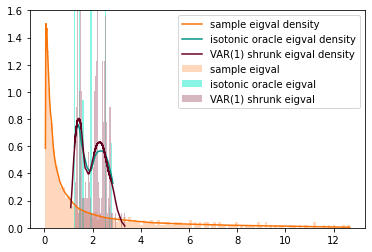

In [145]:
varma_1.hist(
    show_lambdas=True,
    show_lambdas_density=True,
    show_oracle_mwcv_iso=True,
    show_oracle_mwcv_iso_density=True,
    show_xi=True,
    show_xi_density=True,
    ylim=(0, 1.6)
)

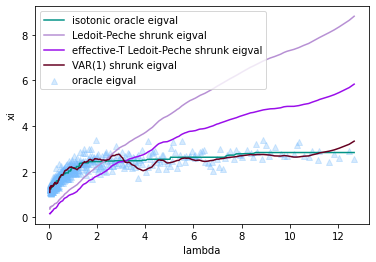

In [146]:
varma_1.plot(
    show_oracle_mwcv=True,
    show_oracle_mwcv_iso=True,
    show_xi_LP=True,
    show_xi_LP_eff_best_oracle_mwcv=True,
    show_xi=True,
)

#### 4.2.1.7. Frobenius ratio

In [147]:
varma_1.frobenius_ratio(
    x=varma_1.xi,
    C=sim_1.population_covariance.C
)

0.12656107439631362

### 4.2.2. Example 2

In [148]:
varma_2 = VarmaShrinkage(
    Y=sim_2.Y,
    T=T,
    T_out=T_out,
    tau_eff_list=tau_eff_list
)

varma_2.set_params(
    a_list=sim_2.auto_covariance.a_list,
    b_list=sim_2.auto_covariance.b_list
)

varma_2.name

'VMA(1)'

In [149]:
varma_2.calculate_xi(
    calculate_epanechnikov_estimates_xi=True
)

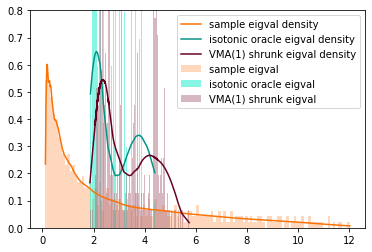

In [150]:
varma_2.hist(
    show_lambdas=True,
    show_lambdas_density=True,
    show_oracle_mwcv_iso=True,
    show_oracle_mwcv_iso_density=True,
    show_xi=True,
    show_xi_density=True,
    ylim=(0, 0.8)
)

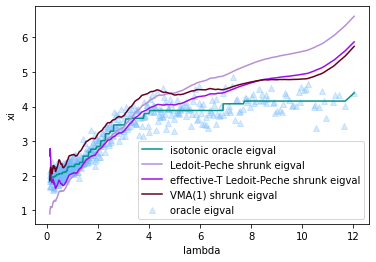

In [151]:
varma_2.plot(
    show_oracle_mwcv=True,
    show_oracle_mwcv_iso=True,
    show_xi_LP=True,
    show_xi_LP_eff_best_oracle_mwcv=True,
    show_xi=True,
)

In [152]:
varma_2.frobenius_ratio(
    x=varma_2.xi,
    C=sim_2.population_covariance.C
)

0.3562417959646359

### 4.2.3. Example 3

In [153]:
varma_3 = VarmaShrinkage(
    Y=sim_3.Y,
    T=T,
    T_out=T_out,
    tau_eff_list=tau_eff_list
)

varma_3.set_params(
    a_list=sim_3.auto_covariance.a_list,
    b_list=sim_3.auto_covariance.b_list
)

varma_3.name

'VARMA(1, 1)'

In [154]:
varma_3.calculate_xi(
    calculate_epanechnikov_estimates_xi=True
)

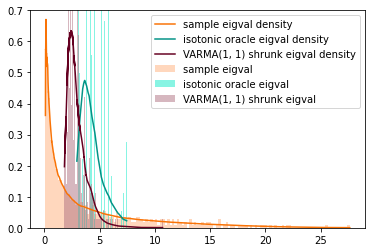

In [155]:
varma_3.hist(
    show_lambdas=True,
    show_lambdas_density=True,
    show_oracle_mwcv_iso=True,
    show_oracle_mwcv_iso_density=True,
    show_xi=True,
    show_xi_density=True,
    ylim=(0, 0.7)
)

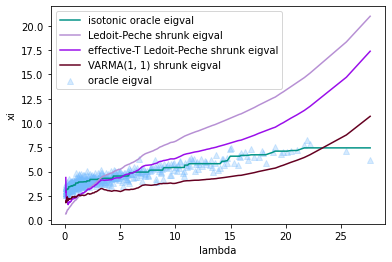

In [156]:
varma_3.plot(
    show_oracle_mwcv=True,
    show_oracle_mwcv_iso=True,
    show_xi_LP=True,
    show_xi_LP_eff_best_oracle_mwcv=True,
    show_xi=True,
)

In [157]:
varma_3.frobenius_ratio(
    x=varma_3.xi,
    C=sim_3.population_covariance.C
)

0.134160248847687

## 4.3. Fitting VARMA parameters to the oracle eigenvalues

### 4.3.1. Introduction

When we defined a shrinkage model above, we "cheated" in that we provided it with the VARMA parameters precisely equal to the ones we'd used to generate the data (here: the auto-correlation time $\tau$) - and this information is in principle unknown. Furthermore, it turns out that if we generate data with some VARMA parameters, but a _non-Gaussian_ distribution (e.g. Student-t), even "cheating" this way does not guarantee an optimal performance: the Frobenius ratio may be worse than even Ledoit-Péché shrinkage. Indeed, the shrinkage formula assumes a Gaussian basin of distributions. This matter is only more pronounced for real-world data, when we don't know the underlying data-generating model, so can't even "cheat".

To alleviate this difficulty, in this section we'll look at the problem from a different angle. Having some sample eigenvalues $\lambda_{i}$, be it generated synthetically according to some model (which suppose is unknown to us), or coming from a real-world dataset, we are at a loss as how to choose a shrinkage model. But what we can do is:

- choose a _family_ of shrinkage models, say `VarmaShrinkage` of given $(r_{1}, r_{2})$, and a _grid_ of parameters of this family; the `grid` should be a list of dictionaries, each dictionary corresponding to the kwargs in the shrinkage model;

- then calculate the shrunk eigenvalues $\xi_{i}$ for every parameter set from the grid, from the "noisy" $\lambda_{i}$'s;

- on the other hand, calculate the oracle eigenvalues $\xi^{ \textrm{oracle} }_{i}$ from the dataset via the moving-window cross-validation procedure;

- for every parameter set from the grid, then, compute some given error function between $\xi_{i}$ and $\xi^{ \textrm{oracle} }_{i}$, and choose this set of parameters for which this error is minimal; the error may be e.g. `loss='mse'`.

This procedure is accomplished by the `fit` method, with `optimizer='brute'`. In other words, while so far we've done only _prediction_, with parameters conjured out of thin air, now we focus on _fitting_; and we do so by a simple brute-force search of a minimum. Our class supports other optimizers, such as gradient descent, but brute force turns out to be quite effective, especially when fitting a one-dimensional exp-decay case, i.e., VAR(1) shrinkage with $a_{0} = \sqrt{1 - b_{1}^{2}}$ and $b_{1} = \exp (-1 / \tau)$, for one parameter $\tau$.

In [158]:
grid = [{'tau': tau} for tau in tau_eff_list]

In [234]:
grid_better = [
    {'a_list': [a0, a1], 'b_list': [b1]}
    for a0 in [0.8]
    for a1 in [0.2, 0.3, 0.4, 0.5, 0.6]
    for b1 in [0.2, 0.3, 0.4, 0.5, 0.6]
]

len(grid_better)

25

### 4.3.2. Example 1

#### 4.3.2.1. Fitting VAR(1)

In [159]:
varma_1_fit = VarmaShrinkage(
    Y=sim_1.Y,
    T=T,
    T_out=T_out,
    tau_eff_list=tau_eff_list
)

varma_1_fit.name

'Ledoit-Peche'

In [160]:
varma_1_fit.fit_params(
    grid=grid
)

  0%|          | 0/50 [00:00<?, ?it/s]

In [161]:
varma_1_fit.name

'VAR(1)'

In [207]:
varma_1_fit.params_dict_best

{'tau': 2.9000000000000004}

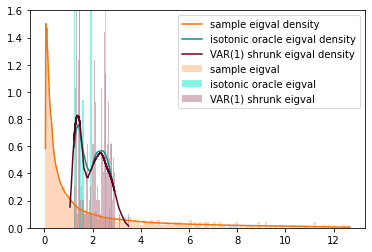

In [162]:
varma_1_fit.hist(
    show_lambdas=True,
    show_lambdas_density=True,
    show_oracle_mwcv_iso=True,
    show_oracle_mwcv_iso_density=True,
    show_xi=True,
    show_xi_density=True,
    ylim=(0, 1.6)
)

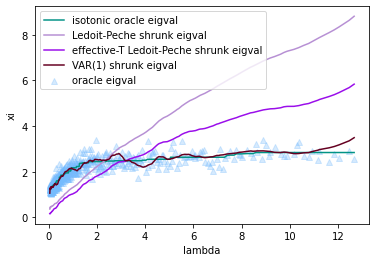

In [163]:
varma_1_fit.plot(
    show_oracle_mwcv=True,
    show_oracle_mwcv_iso=True,
    show_xi_LP=True,
    show_xi_LP_eff_best_oracle_mwcv=True,
    show_xi=True,
)

In [164]:
varma_1_fit.frobenius_ratio(
    x=varma_1_fit.xi,
    C=sim_1.population_covariance.C
)

0.12664125172790253

#### 4.3.2.2. Fitting VARMA(1, 1)

In [235]:
varma_1_fit_better = VarmaShrinkage(
    Y=sim_1.Y,
    T=T,
    T_out=T_out,
    tau_eff_list=tau_eff_list
)

varma_1_fit_better.name

'Ledoit-Peche'

In [236]:
varma_1_fit_better.fit_params(
    grid=grid_better
)

  0%|          | 0/25 [00:00<?, ?it/s]

In [237]:
varma_1_fit_better.name

'VARMA(1, 1)'

In [238]:
varma_1_fit_better.params_dict_best

{'a_list': [0.8, 0.2], 'b_list': [0.6]}

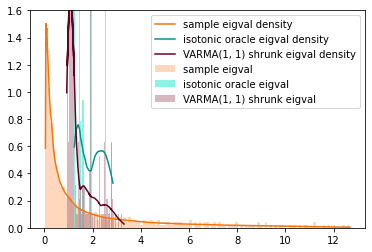

In [239]:
varma_1_fit_better.hist(
    show_lambdas=True,
    show_lambdas_density=True,
    show_oracle_mwcv_iso=True,
    show_oracle_mwcv_iso_density=True,
    show_xi=True,
    show_xi_density=True,
    ylim=(0, 1.6)
)

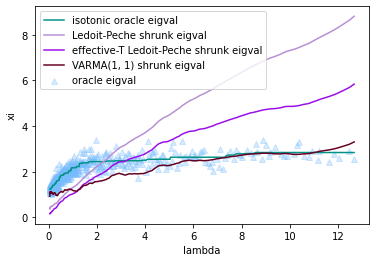

In [240]:
varma_1_fit_better.plot(
    show_oracle_mwcv=True,
    show_oracle_mwcv_iso=True,
    show_xi_LP=True,
    show_xi_LP_eff_best_oracle_mwcv=True,
    show_xi=True,
)

In [241]:
varma_1_fit_better.frobenius_ratio(
    x=varma_1_fit_better.xi,
    C=sim_1.population_covariance.C
)

0.18822746514176997

### 4.3.3. Example 2

#### 4.3.3.1. Fitting VAR(1)

In [165]:
varma_2_fit = VarmaShrinkage(
    Y=sim_2.Y,
    T=T,
    T_out=T_out,
    tau_eff_list=tau_eff_list
)

varma_2_fit.name

'Ledoit-Peche'

In [166]:
varma_2_fit.fit_params(
    grid=grid
)

  0%|          | 0/50 [00:00<?, ?it/s]

In [167]:
varma_2_fit.name

'VAR(1)'

In [206]:
varma_2_fit.params_dict_best

{'tau': 1.1}

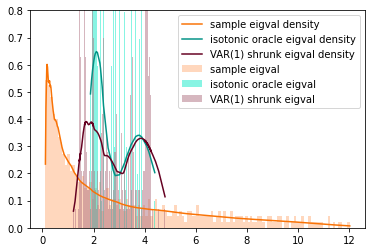

In [168]:
varma_2_fit.hist(
    show_lambdas=True,
    show_lambdas_density=True,
    show_oracle_mwcv_iso=True,
    show_oracle_mwcv_iso_density=True,
    show_xi=True,
    show_xi_density=True,
    ylim=(0, 0.8)
)

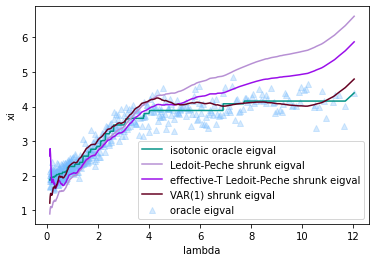

In [169]:
varma_2_fit.plot(
    show_oracle_mwcv=True,
    show_oracle_mwcv_iso=True,
    show_xi_LP=True,
    show_xi_LP_eff_best_oracle_mwcv=True,
    show_xi=True,
)

In [170]:
varma_2_fit.frobenius_ratio(
    x=varma_2_fit.xi,
    C=sim_2.population_covariance.C
)

0.2440570263235798

#### 4.3.3.2. Fitting VARMA(1, 1)

In [212]:
varma_2_fit_better = VarmaShrinkage(
    Y=sim_2.Y,
    T=T,
    T_out=T_out,
    tau_eff_list=tau_eff_list
)

varma_2_fit_better.name

'Ledoit-Peche'

In [213]:
varma_2_fit_better.fit_params(
    grid=grid_better
)

  0%|          | 0/25 [00:00<?, ?it/s]

In [214]:
varma_2_fit_better.name

'VARMA(1, 1)'

In [215]:
varma_2_fit_better.params_dict_best

{'a_list': [0.8, 0.4], 'b_list': [0.2]}

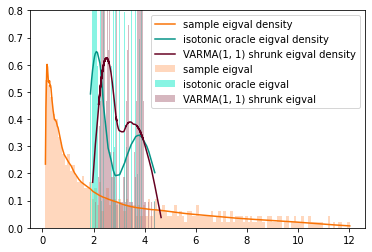

In [216]:
varma_2_fit_better.hist(
    show_lambdas=True,
    show_lambdas_density=True,
    show_oracle_mwcv_iso=True,
    show_oracle_mwcv_iso_density=True,
    show_xi=True,
    show_xi_density=True,
    ylim=(0, 0.8)
)

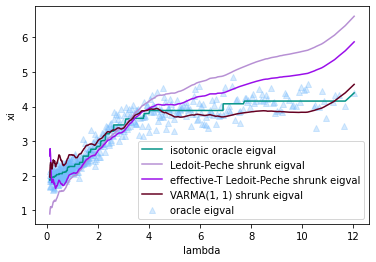

In [217]:
varma_2_fit_better.plot(
    show_oracle_mwcv=True,
    show_oracle_mwcv_iso=True,
    show_xi_LP=True,
    show_xi_LP_eff_best_oracle_mwcv=True,
    show_xi=True,
)

In [218]:
varma_2_fit_better.frobenius_ratio(
    x=varma_2_fit_better.xi,
    C=sim_2.population_covariance.C
)

0.24806722413889412

### 4.3.4. Example 3

#### 4.3.4.1. Fitting VAR(1)

In [171]:
varma_3_fit = VarmaShrinkage(
    Y=sim_3.Y,
    T=T,
    T_out=T_out,
    tau_eff_list=tau_eff_list
)

varma_3_fit.name

'Ledoit-Peche'

In [172]:
varma_3_fit.fit_params(
    grid=grid
)

  0%|          | 0/50 [00:00<?, ?it/s]

In [173]:
varma_3_fit.name

'VAR(1)'

In [205]:
varma_3_fit.params_dict_best

{'tau': 2.0}

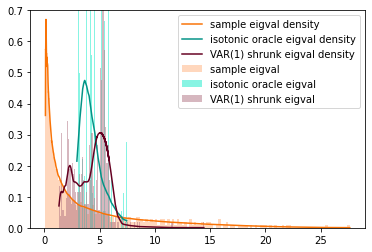

In [174]:
varma_3_fit.hist(
    show_lambdas=True,
    show_lambdas_density=True,
    show_oracle_mwcv_iso=True,
    show_oracle_mwcv_iso_density=True,
    show_xi=True,
    show_xi_density=True,
    ylim=(0, 0.7)
)

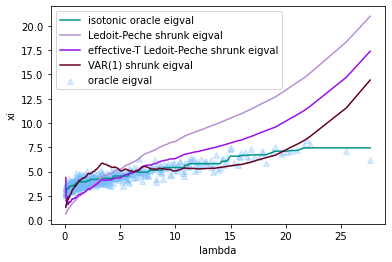

In [175]:
varma_3_fit.plot(
    show_oracle_mwcv=True,
    show_oracle_mwcv_iso=True,
    show_xi_LP=True,
    show_xi_LP_eff_best_oracle_mwcv=True,
    show_xi=True,
)

In [176]:
varma_3_fit.frobenius_ratio(
    x=varma_3_fit.xi,
    C=sim_3.population_covariance.C
)

0.3714833501828617

#### 4.3.4.2. Fitting VARMA(1, 1)

In [201]:
varma_3_fit_better = VarmaShrinkage(
    Y=sim_3.Y,
    T=T,
    T_out=T_out,
    tau_eff_list=tau_eff_list
)

varma_3_fit_better.name

'Ledoit-Peche'

In [203]:
varma_3_fit_better.fit_params(
    grid=grid_better
)

  0%|          | 0/25 [00:00<?, ?it/s]

In [208]:
varma_3_fit_better.name

'VARMA(1, 1)'

In [204]:
varma_3_fit_better.params_dict_best

{'a_list': [0.8, 0.2], 'b_list': [0.5]}

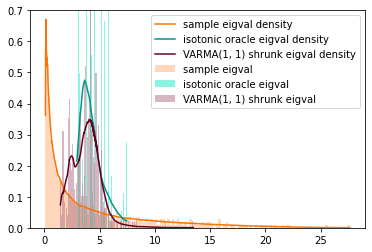

In [210]:
varma_3_fit_better.hist(
    show_lambdas=True,
    show_lambdas_density=True,
    show_oracle_mwcv_iso=True,
    show_oracle_mwcv_iso_density=True,
    show_xi=True,
    show_xi_density=True,
    ylim=(0, 0.7)
)

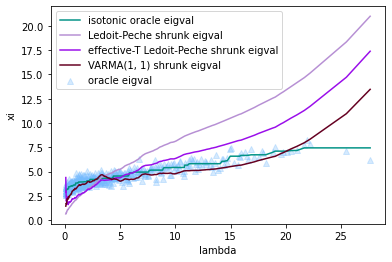

In [211]:
varma_3_fit_better.plot(
    show_oracle_mwcv=True,
    show_oracle_mwcv_iso=True,
    show_xi_LP=True,
    show_xi_LP_eff_best_oracle_mwcv=True,
    show_xi=True,
)

In [209]:
varma_3_fit_better.frobenius_ratio(
    x=varma_3_fit_better.xi,
    C=sim_3.population_covariance.C
)

0.2716779787792975

### 4.3.5. Summary of Frobenius ratios and plots

#### 4.3.5.1. Summary of Frobenius ratios

In [177]:
import pandas as pd

In [242]:
frobenius_ratios_examples = pd.DataFrame(
    columns = [f'Example {i + 1}' for i in range(3)],
    index = [
        'oracle_mwcv',
        'oracle_mwcv_iso',
        'xi_LP',
        'xi_LP_eff',
        'xi',
        'xi_fit_VAR_1',
        'xi_fit_VARMA_1_1',
    ]
)

for i, (sim, sample, lp, varma, varma_fit, varma_fit_better) in enumerate(
    zip(
        [sim_1, sim_2, sim_3],
        [sample_1, sample_2, sample_3],
        [lp_1, lp_2, lp_3],
        [varma_1, varma_2, varma_3],
        [varma_1_fit, varma_2_fit, varma_3_fit],
        [varma_1_fit_better, varma_2_fit_better, varma_3_fit_better],
    )
):
    frobenius_ratios_examples[f'Example {i + 1}'] = [
        sample.frobenius_ratio(
            x=sample.xi_oracle_mwcv,
            C=sim.population_covariance.C
        ),
        sample.frobenius_ratio(
            x=sample.xi_oracle_mwcv_iso,
            C=sim.population_covariance.C
        ),
        lp.frobenius_ratio(
            x=lp.xi_LP,
            C=sim.population_covariance.C
        ),
        lp.frobenius_ratio(
            x=lp.xi_LP_eff_best_oracle_mwcv,
            C=sim.population_covariance.C
        ),
        varma.frobenius_ratio(
            x=varma.xi,
            C=sim.population_covariance.C
        ),
        varma_fit.frobenius_ratio(
            x=varma_fit.xi,
            C=sim.population_covariance.C
        ),
        varma_fit_better.frobenius_ratio(
            x=varma_fit_better.xi,
            C=sim.population_covariance.C
        ),
    ]

frobenius_ratios_examples

,Example 1,Example 2,Example 3
oracle_mwcv,0.133167,0.230514,0.344600
oracle_mwcv_iso,0.124710,0.224136,0.340464
xi_LP,0.526905,0.332414,0.595377
xi_LP_eff,0.327603,0.263000,0.370632
xi,0.126561,0.356242,0.134160
xi_fit_VAR_1,0.126641,0.244057,0.371483
xi_fit_VARMA_1_1,0.188227,0.248067,0.271678


#### 4.3.5.2. Summary of plots

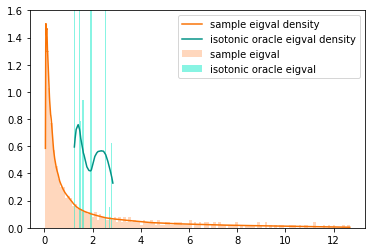

In [266]:
sample_1.hist(
    show_lambdas=True,
    show_lambdas_density=True,
    show_oracle_mwcv_iso=True,
    show_oracle_mwcv_iso_density=True,
    ylim=(0, 1.6),
    savefig='figures/example_1_hist_lambdas_xi_oracle_mwcv_iso.png'
)

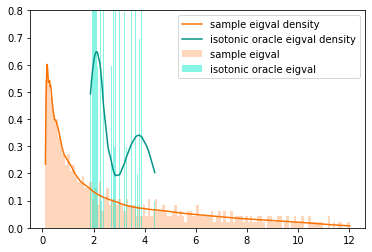

In [267]:
sample_2.hist(
    show_lambdas=True,
    show_lambdas_density=True,
    show_oracle_mwcv_iso=True,
    show_oracle_mwcv_iso_density=True,
    ylim=(0, 0.8),
    savefig='figures/example_2_hist_lambdas_xi_oracle_mwcv_iso.png'
)

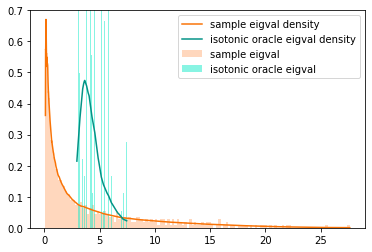

In [268]:
sample_3.hist(
    show_lambdas=True,
    show_lambdas_density=True,
    show_oracle_mwcv_iso=True,
    show_oracle_mwcv_iso_density=True,
    ylim=(0, 0.7),
    savefig='figures/example_3_hist_lambdas_xi_oracle_mwcv_iso.png'
)

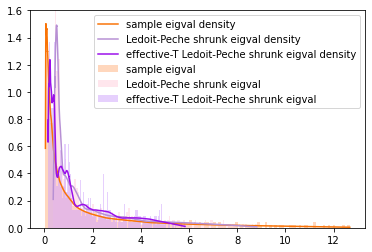

In [269]:
lp_1.hist(
    show_lambdas=True,
    show_lambdas_density=True,
    show_xi_LP=True,
    show_xi_LP_density=True,
    show_xi_LP_eff_best_oracle_mwcv=True,
    show_xi_LP_eff_best_oracle_mwcv_density=True,
    ylim=(0, 1.6),
    savefig='figures/example_1_hist_lambdas_xi_LP_xi_LP_eff.png'
)

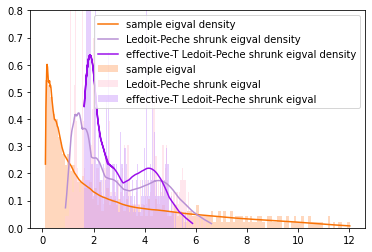

In [270]:
lp_2.hist(
    show_lambdas=True,
    show_lambdas_density=True,
    show_xi_LP=True,
    show_xi_LP_density=True,
    show_xi_LP_eff_best_oracle_mwcv=True,
    show_xi_LP_eff_best_oracle_mwcv_density=True,
    ylim=(0, 0.8),
    savefig='figures/example_2_hist_lambdas_xi_LP_xi_LP_eff.png'
)

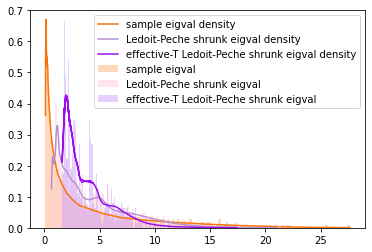

In [271]:
lp_3.hist(
    show_lambdas=True,
    show_lambdas_density=True,
    show_xi_LP=True,
    show_xi_LP_density=True,
    show_xi_LP_eff_best_oracle_mwcv=True,
    show_xi_LP_eff_best_oracle_mwcv_density=True,
    ylim=(0, 0.7),
    savefig='figures/example_3_hist_lambdas_xi_LP_xi_LP_eff.png'
)

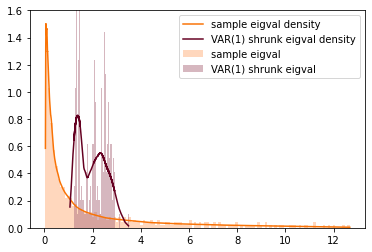

In [272]:
varma_1_fit.hist(
    show_lambdas=True,
    show_lambdas_density=True,
    show_xi=True,
    show_xi_density=True,
    ylim=(0, 1.6),
    savefig='figures/example_1_hist_lambdas_xi_VAR_1_fit.png'
)

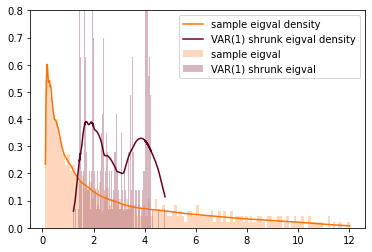

In [273]:
varma_2_fit.hist(
    show_lambdas=True,
    show_lambdas_density=True,
    show_xi=True,
    show_xi_density=True,
    ylim=(0, 0.8),
    savefig='figures/example_2_hist_lambdas_xi_VAR_1_fit.png'
)

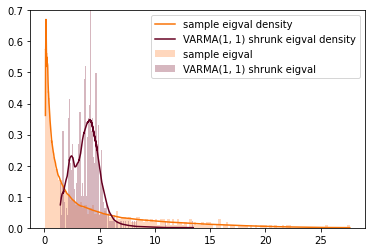

In [274]:
varma_3_better_fit.hist(
    show_lambdas=True,
    show_lambdas_density=True,
    show_xi=True,
    show_xi_density=True,
    ylim=(0, 0.7),
    savefig='figures/example_3_hist_lambdas_xi_VARMA_1_1_fit.png'
)

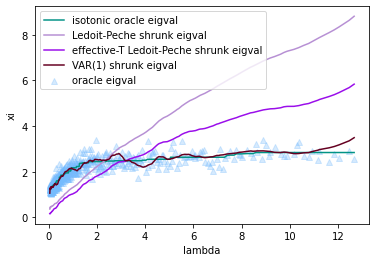

In [275]:
varma_1_fit.plot(
    show_oracle_mwcv=True,
    show_oracle_mwcv_iso=True,
    show_xi_LP=True,
    show_xi_LP_eff_best_oracle_mwcv=True,
    show_xi=True,
    savefig='figures/example_1_plot.png'
)

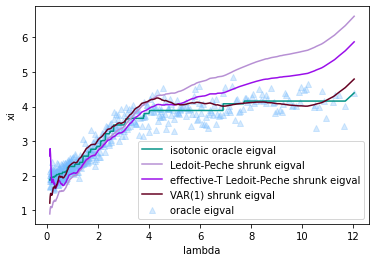

In [276]:
varma_2_fit.plot(
    show_oracle_mwcv=True,
    show_oracle_mwcv_iso=True,
    show_xi_LP=True,
    show_xi_LP_eff_best_oracle_mwcv=True,
    show_xi=True,
    savefig='figures/example_2_plot.png'
)

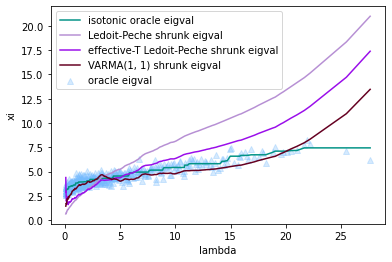

In [277]:
varma_3_better_fit.plot(
    show_oracle_mwcv=True,
    show_oracle_mwcv_iso=True,
    show_xi_LP=True,
    show_xi_LP_eff_best_oracle_mwcv=True,
    show_xi=True,
    savefig='figures/example_3_plot.png'
)

### 4.3.6. Example 4: an S&P500 real-world dataset

#### 4.3.6.1. Loading a real-world dataset

So far we have worked with synthetic (simulated) datasets. But equally well, we may load in a prepared data matrix $\mathbf{Y}$, only making sure it is in the correct format, that is an $N \times T_{\textrm{total}}$ array. To this end, we have a convenience function `load_Y` in the `shrinkage.datasets` module.

Furthermore, there is a `datasets` subdirectory, which contains some prepared real-world data. (Note that we may execute this module, `py -m datasets`; it'll generate the included datasets in the correct format from initial datasets, which come from known sources online.)

In [7]:
from shrinkage.datasets import load_Y

We will demonstrate the above fitting procedure for a financial dataset of returns of the S&P 500 stock index.

In [8]:
Y = load_Y(dataset_name='sp500_5yr')

Y.shape

(470, 1258)

We may now employ the same class, `DataMatrix`, that we have used extensively for simulation. We simply instantiate it with `method='load'` and a matrix `Y` instead of the simulation attributes like `dist`, `C_model`, `A_model`, etc.

In [9]:
real_1 = DataMatrix(
    method='load',
    Y=Y
)

Here we choose `T` in such a way so as to have $q = N/T = 0.5$, like in all the synthetic examples above.

There is one subtlety here: this dataset has a number of _outlying_ sample eigenvalues, separate from the _bulk_. For greater visibility, let's remove some number of top eigenvalues from the spectrum, before embarking on a shrinkage analysis.

In [12]:
T_out = 50

tau_eff_list = np.arange(0.1, 5.1, 0.1)

grid = [{'tau': tau} for tau in tau_eff_list]

grid_better = [
    {'a_list': [a0, a1], 'b_list': [b1]}
    for a0 in [0.8]
    for a1 in [0.2, 0.3, 0.4, 0.5, 0.6]
    for b1 in [0.2, 0.3, 0.4, 0.5, 0.6]
]

#### 4.3.6.2. Fitting VAR(1)

In [13]:
varma_real_1_fit = VarmaShrinkage(
    Y=real_1.Y,
    T=2 * Y.shape[0],
    T_out=T_out,
    tau_eff_list=tau_eff_list,
    n_top=10
)

varma_real_1_fit.name

'Ledoit-Peche'

In [14]:
varma_real_1_fit.fit_params(
    grid=grid
)

  0%|          | 0/50 [00:00<?, ?it/s]

In [15]:
varma_real_1_fit.name

'VAR(1)'

In [29]:
varma_real_1_fit.params_dict_best

{'tau': 1.4000000000000001}

#### 4.3.6.3. Fitting VARMA(1, 1)

In [24]:
varma_real_1_better_fit = VarmaShrinkage(
    Y=real_1.Y,
    T=2 * Y.shape[0],
    T_out=T_out,
    tau_eff_list=tau_eff_list,
    n_top=10
)

varma_real_1_better_fit.name

'Ledoit-Peche'

In [25]:
varma_real_1_better_fit.fit_params(
    grid=grid_better
)

  0%|          | 0/25 [00:00<?, ?it/s]

In [26]:
varma_real_1_better_fit.name

'VARMA(1, 1)'

In [30]:
varma_real_1_better_fit.params_dict_best

{'a_list': [0.8, 0.2], 'b_list': [0.4]}

#### 4.3.6.4. Plots

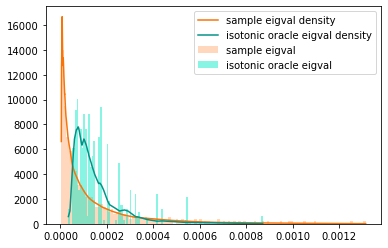

In [18]:
varma_real_1_fit.hist(
    show_lambdas=True,
    show_lambdas_density=True,
    show_oracle_mwcv_iso=True,
    show_oracle_mwcv_iso_density=True,
)

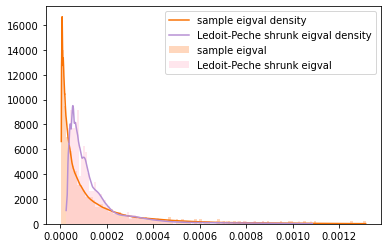

In [19]:
varma_real_1_fit.hist(
    show_lambdas=True,
    show_lambdas_density=True,
    show_xi_LP=True,
    show_xi_LP_density=True,
)

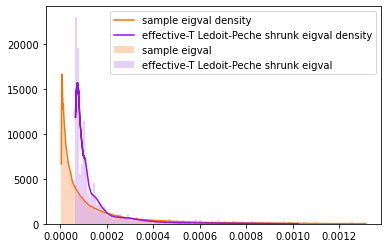

In [20]:
varma_real_1_fit.hist(
    show_lambdas=True,
    show_lambdas_density=True,
    show_xi_LP_eff_best_oracle_mwcv=True,
    show_xi_LP_eff_best_oracle_mwcv_density=True,
)

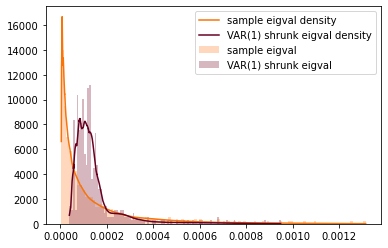

In [22]:
varma_real_1_fit.hist(
    show_lambdas=True,
    show_lambdas_density=True,
    show_xi=True,
    show_xi_density=True,
)

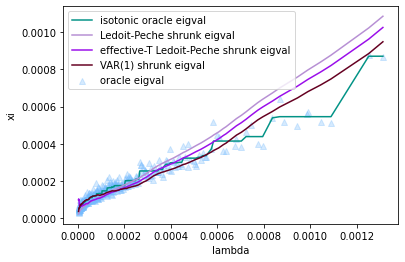

In [17]:
varma_real_1_fit.plot(
    show_oracle_mwcv=True,
    show_oracle_mwcv_iso=True,
    show_xi_LP=True,
    show_xi_LP_eff_best_oracle_mwcv=True,
    show_xi=True,
)

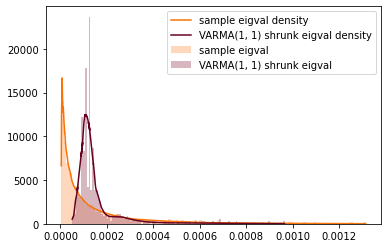

In [27]:
varma_real_1_better_fit.hist(
    show_lambdas=True,
    show_lambdas_density=True,
    show_xi=True,
    show_xi_density=True,
)

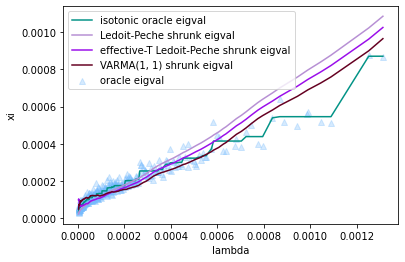

In [28]:
varma_real_1_better_fit.plot(
    show_oracle_mwcv=True,
    show_oracle_mwcv_iso=True,
    show_xi_LP=True,
    show_xi_LP_eff_best_oracle_mwcv=True,
    show_xi=True,
)